In [1]:
# подключаем библиотеки
from geopy.distance import geodesic as gd
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import datetime
import requests

In [2]:
#задаем путь до файла
orders_data_path = r'C:\Users\PC\Desktop\diploma\Data\TumenData\TumenOrders.csv'

#загружаем данные в датафрейм
orders_data = pd.read_csv(orders_data_path,
                          dtype={'OrderId': 'uint32', 'EstimatedTimeArrival': 'int16', 'LoadArea': 'float32',
                                 'FeedPointLatitude': 'float32', 'FeedPointLongitude': 'float32',
                                 'TariffTypeId': 'uint32'},
                          parse_dates=['SetDriverDate', 'ArrivalDriverDate', 'OrderCreationDate'],
                          date_format="%Y-%m-%d %H:%M:%S.%f")

#выводим результат
display(orders_data)

,OrderId,EstimatedTimeArrival,SetDriverDate,ArrivalDriverDate,OrderCreationDate,LoadArea,FeedPointLatitude,FeedPointLongitude,TariffTTypeId
0,3546241840,2,2024-02-23 04:57:42.457,2024-02-23 04:57:50.783,2024-02-23 04:55:57.640,1.0,57.150726,65.534576,66
1,3548209178,3,2024-03-06 11:28:11.437,2024-03-06 11:28:42.560,2024-03-06 11:26:13.280,1.0,57.150726,65.534576,66
2,3545181356,10,2024-02-17 13:36:35.753,2024-02-17 13:45:52.593,2024-02-17 13:34:06.520,1.0,57.150612,65.540314,11
3,3544674788,23,2024-02-15 08:28:35.887,2024-02-15 08:52:51.310,2024-02-15 08:23:50.733,1.0,57.101444,65.592384,27
4,3544741846,4,2024-02-15 14:00:28.757,2024-02-15 14:02:38.143,2024-02-15 13:54:06.180,1.0,57.122231,65.526054,27
...,...,...,...,...,...,...,...,...,...
145643,3549307840,20,2024-03-12 13:11:00.257,2024-03-12 13:27:48.380,2024-03-12 13:10:20.693,1.0,57.101452,65.577003,1084
145644,3549335321,16,2024-03-12 16:35:31.980,2024-03-12 16:50:10.303,2024-03-12 16:34:24.670,1.0,57.204575,65.602242,1084
145645,3549440079,15,2024-03-13 12:20:30.407,2024-03-13 12:36:55.087,2024-03-13 12:09:17.090,1.0,57.110733,65.573792,1084
145646,3549478652,15,2024-03-13 17:39:13.897,2024-03-13 17:45:17.017,2024-03-13 16:59:03.620,1.0,57.115326,65.560928,1084


In [3]:
#задаем смещение времени относительно UTC
tumen_delta_time = datetime.timedelta(hours=5)

#применяем смещение к столбцу с временем создания заказа
orders_data['OrderCreationDate'] = orders_data['OrderCreationDate'] + tumen_delta_time

#выводим результат
display(orders_data)

,OrderId,EstimatedTimeArrival,SetDriverDate,ArrivalDriverDate,OrderCreationDate,LoadArea,FeedPointLatitude,FeedPointLongitude,TariffTTypeId
0,3546241840,2,2024-02-23 04:57:42.457,2024-02-23 04:57:50.783,2024-02-23 09:55:57.640,1.0,57.150726,65.534576,66
1,3548209178,3,2024-03-06 11:28:11.437,2024-03-06 11:28:42.560,2024-03-06 16:26:13.280,1.0,57.150726,65.534576,66
2,3545181356,10,2024-02-17 13:36:35.753,2024-02-17 13:45:52.593,2024-02-17 18:34:06.520,1.0,57.150612,65.540314,11
3,3544674788,23,2024-02-15 08:28:35.887,2024-02-15 08:52:51.310,2024-02-15 13:23:50.733,1.0,57.101444,65.592384,27
4,3544741846,4,2024-02-15 14:00:28.757,2024-02-15 14:02:38.143,2024-02-15 18:54:06.180,1.0,57.122231,65.526054,27
...,...,...,...,...,...,...,...,...,...
145643,3549307840,20,2024-03-12 13:11:00.257,2024-03-12 13:27:48.380,2024-03-12 18:10:20.693,1.0,57.101452,65.577003,1084
145644,3549335321,16,2024-03-12 16:35:31.980,2024-03-12 16:50:10.303,2024-03-12 21:34:24.670,1.0,57.204575,65.602242,1084
145645,3549440079,15,2024-03-13 12:20:30.407,2024-03-13 12:36:55.087,2024-03-13 17:09:17.090,1.0,57.110733,65.573792,1084
145646,3549478652,15,2024-03-13 17:39:13.897,2024-03-13 17:45:17.017,2024-03-13 21:59:03.620,1.0,57.115326,65.560928,1084


In [6]:
#задаем путь до файла
days_off_path = r'C:\Users\PC\Desktop\diploma\Data\TumenData\DaysOff2024.csv'

#загружаем данные в датафрейм
days_off = pd.read_csv(days_off_path, parse_dates=['Date'], date_format="%Y-%m-%d")

#оставляем только дату
days_off['Date'] = [date.date() for date in days_off['Date']]

#выводим результат
display(days_off)

,Date
0,2024-01-01
1,2024-01-02
2,2024-01-03
3,2024-01-04
4,2024-01-05
...,...
113,2024-12-21
114,2024-12-22
115,2024-12-29
116,2024-12-30


In [7]:
#формируем признак "был выходной день"
orders_data['IsWeekend'] = [1 if date_time.date() in days_off['Date'].values else 0 for date_time in
                            orders_data['OrderCreationDate']]

#выводим количество заказов, совершенных в выходной день
print('Количество заказов, совершенных в выходной день =',orders_data['IsWeekend'].sum())

Количество заказов, совершенных в выходной день = 51292


In [8]:
#задаем границы часов пик
rush_hour_time = [datetime.time(6, 0, 0), datetime.time(9, 0, 0), datetime.time(16, 0, 0), datetime.time(19, 0, 0)]

#задаем анонимную функцию, проверяющую выполнялся ли заказ в час пик
is_rush_hour = lambda time: rush_hour_time[0] <= time <= rush_hour_time[1] or rush_hour_time[2] <= time <= \
                            rush_hour_time[3]

#формируем признак "был час пик"
orders_data['IsRushHour'] = [1 if is_rush_hour(date_time.time()) else 0 for date_time in
                             orders_data['OrderCreationDate']]

#выводим количество заказов, совершенных в час пик
print('Количество заказов, совершенных в час пик =',orders_data['IsRushHour'].sum())

Количество заказов, совершенных в час пик = 43822


In [9]:
#создаем функцию для определения были ли осадки, принимаем на вход количество осадков
def check_has_precipitation(amount_precipitation):
    #пытаемся конвертировать количество осадков к float и проверить были ли осадки
    try:
        float_amount_precipitation = float(amount_precipitation)
        return float_amount_precipitation > 0
    #на вход может прийти текст, о том что осадков не было
    except ValueError:
        return False

In [10]:
#задаем путь до файла
weather_data_path = r'C:\Users\PC\Desktop\diploma\Data\TumenData\TumenWeather.csv'

#загружаем данные в датафрейм
weather_data = pd.read_csv(weather_data_path, parse_dates=['Date'], dayfirst=True, sep=';')

#формируем признак "были ли осадки"
weather_data['HasPrecipitation'] = weather_data['RRR'].apply(lambda x: int(check_has_precipitation(x)))

#оставляем только дату и признак
weather_data = weather_data[['Date', 'HasPrecipitation']]

#выводим результат
display(weather_data)

,Date,HasPrecipitation
0,2024-03-14 23:00:00,0
1,2024-03-14 20:00:00,1
2,2024-03-14 17:00:00,0
3,2024-03-14 14:00:00,0
4,2024-03-14 11:00:00,0
...,...,...
227,2024-02-15 14:00:00,0
228,2024-02-15 11:00:00,0
229,2024-02-15 08:00:00,0
230,2024-02-15 05:00:00,0


In [11]:
#объединяем заказы с погодой, получаем все сочетания
orders_with_weather_data = pd.merge(orders_data, weather_data, how='cross')

#вычисляем разницу во времени
orders_with_weather_data['DeltaTime'] = orders_with_weather_data['Date'] - orders_with_weather_data['OrderCreationDate']

#оставляем те варианты, где время создания заказа меньше временных отметок о погоде 
orders_with_weather_data = orders_with_weather_data[orders_with_weather_data['DeltaTime'] > datetime.timedelta(0)]

#сортируем, чтобы найти ближайшую отметку для заказа, группируем и берем первый элемент в каждой группе
orders_data = orders_with_weather_data.sort_values(by=['DeltaTime']).groupby('OrderId', as_index=False).first()

#выводим количество заказов совершенных в осадки
print('Количество заказов совершенных в осадки =',orders_data['HasPrecipitation'].sum())

Количество заказов совершенных в осадки = 4239


<Axes: xlabel='День недели', ylabel='Количество заказов'>

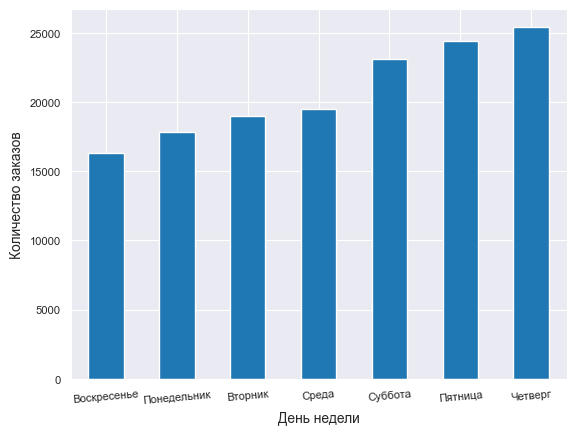

In [12]:
#задаем русские названия для дней недели
localized_day_of_week = ['Понедельник','Вторник','Среда','Четверг','Пятница','Суббота','Воскресенье']
#формируем признак день недели
orders_data['DayOfWeek'] = orders_data['OrderCreationDate'].apply(lambda creation_date: localized_day_of_week[creation_date.weekday()])
#выводим распределение заказов по дням недели(0 - понедельник)
orders_data[['OrderId','DayOfWeek']].groupby('DayOfWeek').count().sort_values(by = 'OrderId').plot(kind='bar', xlabel='День недели', ylabel='Количество заказов',legend=False, rot=5, fontsize=8)

In [13]:
#задаем путь до файла
tumen_drivers_path = r'C:\Users\PC\Desktop\diploma\Data\TumenData\TumenDrivers.csv'

#загружаем данные в датафрейм
tumen_drivers = pd.read_csv(tumen_drivers_path,
                            dtype={'driverid': 'uint32', 'driverlatitude': 'float32', 'driverlongitude': 'float32'},
                            parse_dates=['date'], date_format="%Y-%m-%d %H:%M:%S.%f")

#применяем смещение к столбцу с временем 
tumen_drivers['date'] = tumen_drivers['date'] + tumen_delta_time

#выводим результат
display(tumen_drivers)

,date,driverid,driverlatitude,driverlongitude
0,2024-02-28 10:12:19.875,3055334,57.147938,65.541496
1,2024-02-28 10:12:23.925,3055334,57.147942,65.541504
2,2024-02-28 10:13:20.542,3055334,57.147961,65.541451
3,2024-02-28 10:13:55.698,3055334,57.147953,65.541428
4,2024-02-28 10:14:56.750,3055334,57.148476,65.540443
...,...,...,...,...
37560034,2024-02-27 19:26:20.765,14160477,57.137123,65.539810
37560035,2024-02-27 19:26:55.718,14160477,57.137070,65.539818
37560036,2024-02-27 19:27:30.706,14160477,57.137058,65.539810
37560037,2024-02-27 19:28:05.718,14160477,57.137058,65.539810


In [14]:
#получаем всех уникальных водителей
tumen_unique_drivers = tumen_drivers['driverid'].drop_duplicates()

#выводим результат
display(tumen_unique_drivers)

0            3055334
187          3076862
243          3015408
511          3086835
513           309575
              ...   
37497369    14950055
37503201    14600199
37550655    11068178
37556391    14143057
37559597    14158826
Name: driverid, Length: 13555, dtype: uint32

In [15]:
#задаем путь до файла
drivers_with_auto_path = r'C:\Users\PC\Desktop\diploma\Data\TumenData\DriversWithAuto.csv'

#загружаем данные в датафрейм
drivers_with_auto = pd.read_csv(drivers_with_auto_path)

#выводим результат
display(drivers_with_auto)

,DriverId,AutoId
0,100016,11879094
1,100039,6805230
2,100056,3794953
3,100056,5566330
4,100056,16216391
...,...,...
4339950,15010577,16652667
4339951,15010591,5400362
4339952,15010591,16652692
4339953,15010594,16652691


In [16]:
#объединяем водителей с их автомобилями
tumen_drivers_with_auto = pd.merge(tumen_unique_drivers,
                                   drivers_with_auto, left_on=['driverid'], right_on=['DriverId'], how='left')

#удаляем некорректные данные 
tumen_drivers_with_auto = tumen_drivers_with_auto.dropna()

#выводим результат
display(tumen_drivers_with_auto)

,driverid,DriverId,AutoId
0,3055334,3055334.0,16651637.0
1,3076862,3076862.0,9416158.0
2,3015408,3015408.0,12707818.0
3,3015408,3015408.0,13183526.0
4,3086835,3086835.0,5495905.0
...,...,...,...
19054,14950055,14950055.0,16562931.0
19055,14600199,14600199.0,16075218.0
19056,11068178,11068178.0,12185497.0
19057,14143057,14143057.0,15446828.0


In [18]:
#задаем url для получения списка доступных тарифов для водителей
url = 'https://dev-drvtariff.taxsee.com/api/v1/tariffs/drivers/find-all'

#создаем список, который будем заполнять данными вида [driver_id, tariff_type_id]
available_drivers_tariffs = []

#идем по каждому водителю
for driver in tumen_drivers_with_auto.values:

    #получаем id водителя
    driverId = int(driver[0])

    #формируем тело запроса
    request = {
        "driverId": str(driverId),
        "autoId": str(int(driver[2])),
        "placeId": 3
    }

    #отправляем запрос
    response = requests.post(url, json=request)

    #формируем нужные данные
    for tariff in response.json()['tariffs']:
        available_drivers_tariffs.append([driverId, tariff['tariffTypeId']])

#оставляем уникальные значения, так как могут быть два автомобиля с пересекающимися тарифами 
available_drivers_tariffs = np.unique(available_drivers_tariffs, axis=0)
#выводим результат
display(available_drivers_tariffs)

array([[  100011,       27],
       [  100011,       43],
       [  100011,       67],
       ...,
       [14975464,     1429],
       [14975464,     1430],
       [14975464,     1475]])

In [19]:
#задаем путь до файла
drivers_info_path = r'C:\Users\PC\Desktop\diploma\Data\DriversInfoV2.csv'

#загружаем данные в датафрейм
drivers_info = pd.read_csv(drivers_info_path,
                           dtype={'DriverId': 'uint32', 'Rang': 'float32', 'CountCompleteAutoPlain': pd.Int32Dtype(),
                                  'CountCompleteOrders': pd.Int32Dtype(), 'CountFailureAutoPlain': pd.Int32Dtype()},
                           parse_dates=['UpdateRangDate'], date_format="%Y-%m-%d %H:%M:%S.%f")

#заменяем null на 0, так ак для этого набора это идентичные значения
drivers_info = drivers_info.fillna(0)

drivers_info = drivers_info[drivers_info['DriverId'].isin(tumen_unique_drivers)]

#выводим результат
display(drivers_info)

,DriverId,Rang,CountCompleteAutoPlain,CountFailureAutoPlain,CountCompleteOrders,UpdateRangDate
26239,3684255,0.55,5,21,27,2015-10-28 05:14:44.193
41010,3831677,0.00,4,0,32,2015-10-28 12:22:20.363
44199,3851294,0.00,0,3,8,2015-10-28 13:13:18.377
57222,3852812,0.91,9,3,81,2015-11-18 21:43:17.737
80599,3749857,0.86,9,3,40,2015-12-30 21:53:21.070
...,...,...,...,...,...,...
9194826,10450403,0.98,8,0,27,2024-03-18 15:21:07.387
9194864,8209578,0.92,0,2,60,2024-03-18 15:21:08.013
9194892,14900787,0.97,0,0,37,2024-03-18 15:21:08.397
9194967,5277601,0.81,57,42,57,2024-03-18 15:26:09.123


In [20]:
#формируем из полученных данных датафрейм
available_drivers_tariffs_df = pd.DataFrame(available_drivers_tariffs, columns=['DriverId', 'TariffTypeId']) 

available_drivers_tariffs_df.to_csv("AvailableDriversTariffs", index=False)

In [21]:
#создаем функция для расчета дистанции между водителем и точкой подачи
def calculate_distance(driver_coord, feed_point):
    return int(gd((driver_coord[2], driver_coord[3]),
                  (feed_point[6], feed_point[7])).meters)

In [22]:
#создаем функцию, которая отбирает водителей, для которых тип тарифа заказа совпадает с доступными ему типами тарифов
def get_suitable_drivers(drivers_ids, tariff_type_id):
    return [driver_id for driver_id in drivers_ids if
            tariff_type_id in drivers_with_available_tariffs.get(driver_id, [])]

In [23]:
def get_amount_orders_nearby(order):
    delta_time = (orders_data['OrderCreationDate'] - order[4]).dt.total_seconds()
    mask_delta_time_1m = delta_time.between(0, 60) & (orders_data['OrderId'] != order[0])
    orders_within_2m = orders_data[mask_delta_time_1m].copy()
    orders_within_2m['DistanceToOrder'] = [calculate_distance_between_order(order_within_2m, order) for order_within_2m
                                           in orders_within_2m.values]
    orders_nearby_2km = orders_within_2m[orders_within_2m['DistanceToOrder'] < 2000]
    return orders_nearby_2km.shape[0]

In [24]:
#создаем функцию для вычисления вероятности отказа от заказа случайно выбранного водителя
def calculate_probability_refusal_order(drivers_ids, create_order_date):
    #если водителей нет, то считаем, что вероятность отказа равна 1
    if len(drivers_ids) == 0:
        return 1

    #оставляем статистическую информацию о нужных водителях
    drivers_info_fix_date = drivers_info[drivers_info['DriverId'].isin(drivers_ids)].copy()

    #находим разницу во времени, чтобы выбрать самые актуальные данные на момент создания заказа
    drivers_info_fix_date['DeltaUpdateDate'] = (create_order_date - drivers_info_fix_date['UpdateRangDate']).abs()

    #оставляем актуальные данные
    drivers_info_fix_date = drivers_info_fix_date.sort_values(by='DeltaUpdateDate').groupby(
        'DriverId').first().reset_index()

    #учитываем водителей, которые выполнили больше одного заказа
    drivers_info_fix_date = drivers_info_fix_date[
        (drivers_info_fix_date['CountCompleteAutoPlain'] > 0) | (drivers_info_fix_date['CountFailureAutoPlain'] > 0)]

    #вычисляем количество водителей
    count_drivers = drivers_info_fix_date.shape[0]

    #если водителей после фильтрации не осталось, считаем что вероятность отказа 0.5
    if count_drivers == 0:
        return 0.5

    #вычисляем вероятность отказа от заказа для каждого водителя
    probability = drivers_info_fix_date['CountFailureAutoPlain'] / (
                drivers_info_fix_date['CountFailureAutoPlain'] + drivers_info_fix_date['CountCompleteAutoPlain'])

    #вычисляем вероятность отказа случайно выбранного водителя
    return probability.sum() / count_drivers

In [25]:
#создаем функция для расчета дистанции между водителем и точкой подачи
def calculate_distance_between_order(first_order, second_order):
    return int(gd((first_order[6], first_order[7]),
                  (second_order[6], second_order[7])).meters)

In [26]:
def process_order(order):
    creation_date = order[4]
    delta_time = (tumen_drivers['date'] - creation_date).dt.total_seconds()
    mask_delta_time_15s = delta_time.between(0, 15)
    drivers_within_30s = tumen_drivers[mask_delta_time_15s].drop_duplicates(subset=['driverid'])

    suitable_drivers_within_30s = get_suitable_drivers(drivers_within_30s['driverid'].values, order[8])

    drivers_within_30s = drivers_within_30s[drivers_within_30s['driverid'].isin(suitable_drivers_within_30s)]

    drivers_within_30s['DistanceToOrder'] = [calculate_distance(driver, order) for driver in drivers_within_30s.values]

    mask_order_less500m = drivers_within_30s['DistanceToOrder'] < 500
    mask_order_less1000m = (drivers_within_30s['DistanceToOrder'] >= 500) & (
            drivers_within_30s['DistanceToOrder'] < 1000)
    mask_order_less2000m = (drivers_within_30s['DistanceToOrder'] >= 1000) & (
            drivers_within_30s['DistanceToOrder'] < 2000)

    drivers_radius_500m = drivers_within_30s[mask_order_less500m]
    drivers_radius_1000m = drivers_within_30s[mask_order_less1000m]
    drivers_radius_2000m = drivers_within_30s[mask_order_less2000m]

    count_drivers_500m = len(drivers_radius_500m)
    count_drivers_1000m = len(drivers_radius_1000m)
    count_drivers_2000m = len(drivers_radius_2000m)

    distance_first_nearest_driver = 10000
    distance_second_nearest_driver = 10000
    distance_third_nearest_driver = 10000

    probability_refusal_order_first_nearest_driver = 1
    probability_refusal_order_second_nearest_driver = 1
    probability_refusal_order_third_nearest_driver = 1

    sorted_drivers_within_30s = drivers_within_30s.sort_values(by='DistanceToOrder')

    if sorted_drivers_within_30s.shape[0] >= 3:
        distance_first_nearest_driver = sorted_drivers_within_30s['DistanceToOrder'].iloc[0]
        distance_second_nearest_driver = sorted_drivers_within_30s['DistanceToOrder'].iloc[1]
        distance_third_nearest_driver = sorted_drivers_within_30s['DistanceToOrder'].iloc[2]
        probability_refusal_order_first_nearest_driver = calculate_probability_refusal_order(
            [sorted_drivers_within_30s['driverid'].iloc[0]], creation_date)
        probability_refusal_order_second_nearest_driver = calculate_probability_refusal_order(
            [sorted_drivers_within_30s['driverid'].iloc[1]], creation_date)
        probability_refusal_order_third_nearest_driver = calculate_probability_refusal_order(
            [sorted_drivers_within_30s['driverid'].iloc[2]], creation_date)
    elif sorted_drivers_within_30s.shape[0] == 2:
        distance_first_nearest_driver = sorted_drivers_within_30s['DistanceToOrder'].iloc[0]
        distance_second_nearest_driver = sorted_drivers_within_30s['DistanceToOrder'].iloc[1]
        probability_refusal_order_first_nearest_driver = calculate_probability_refusal_order(
            [sorted_drivers_within_30s['driverid'].iloc[0]], creation_date)
        probability_refusal_order_second_nearest_driver = calculate_probability_refusal_order(
            [sorted_drivers_within_30s['driverid'].iloc[1]], creation_date)
    elif sorted_drivers_within_30s.shape[0] == 1:
        distance_first_nearest_driver = sorted_drivers_within_30s['DistanceToOrder'].iloc[0]
        probability_refusal_order_first_nearest_driver = calculate_probability_refusal_order(
            [sorted_drivers_within_30s['driverid'].iloc[0]], creation_date)

    probability_refusal_order500m = calculate_probability_refusal_order(drivers_radius_500m['driverid'], creation_date)
    probability_refusal_order1000m = calculate_probability_refusal_order(drivers_radius_1000m['driverid'],
                                                                         creation_date)
    probability_refusal_order2000m = calculate_probability_refusal_order(drivers_radius_2000m['driverid'],
                                                                         creation_date)
    
    orders_nearby_2km = get_amount_orders_nearby(order)

    return [count_drivers_500m, count_drivers_1000m, count_drivers_2000m, distance_first_nearest_driver,
            distance_second_nearest_driver, distance_third_nearest_driver,
            probability_refusal_order_first_nearest_driver, probability_refusal_order_second_nearest_driver,
            probability_refusal_order_third_nearest_driver, probability_refusal_order500m,
            probability_refusal_order1000m, probability_refusal_order2000m, orders_nearby_2km]


#получаем словарь, где ключ идентификатор водителя, а значение список доступных ему тарифов 
drivers_with_available_tariffs = available_drivers_tariffs_df.groupby('DriverId')['TariffTypeId'].apply(list).to_dict()
results = Parallel(n_jobs=6)(delayed(process_order)(order) for order in orders_data.values)

drivers_sings_df = pd.DataFrame(results, columns=['CountDrivers500m', 'CountDrivers1000m', 'CountDrivers2000m',
                                                  'DistanceToFirstNearestDriver', 'DistanceToSecondNearestDriver',
                                                  'DistanceToThirdNearestDriver',
                                                  'ProbabilityRefusalOrderFirstNearestDriver',
                                                  'ProbabilityRefusalOrderSecondNearestDriver',
                                                  'ProbabilityRefusalOrderThirdNearestDriver',
                                                  'ProbabilityRefusalOrder500m', 'ProbabilityRefusalOrder1000m',
                                                  'ProbabilityRefusalOrder2000m', 'CountOrdersAround'])

In [27]:
orders_data = pd.concat([orders_data, drivers_sings_df], axis=1, join='inner')
orders_data.describe()

,OrderId,EstimatedTimeArrival,SetDriverDate,ArrivalDriverDate,OrderCreationDate,LoadArea,FeedPointLatitude,FeedPointLongitude,TariffTTypeId,IsWeekend,...,DistanceToFirstNearestDriver,DistanceToSecondNearestDriver,DistanceToThirdNearestDriver,ProbabilityRefusalOrderFirstNearestDriver,ProbabilityRefusalOrderSecondNearestDriver,ProbabilityRefusalOrderThirdNearestDriver,ProbabilityRefusalOrder500m,ProbabilityRefusalOrder1000m,ProbabilityRefusalOrder2000m,CountOrdersAround
count,1.456480e+05,145648.000000,145648,145648,145648,145648.000000,145648.000000,145648.000000,145648.000000,145648.000000,...,1.456480e+05,1.456480e+05,1.456480e+05,145648.000000,145648.000000,145648.000000,145648.000000,145648.000000,145648.000000,145648.000000
mean,3.547036e+09,7.074302,2024-02-28 05:10:14.362316544,2024-02-28 05:15:50.621456384,2024-02-28 10:06:04.875046656,1.123619,57.139690,65.565132,1345.799077,0.352164,...,6.620202e+02,9.040920e+02,1.099014e+03,0.478504,0.480489,0.482817,0.607801,0.539690,0.500796,0.560948
min,3.544585e+09,2.000000,2024-02-15 00:01:58.203000,2024-02-15 00:03:33.630000,2024-02-15 05:00:25.540000,1.000000,0.000000,0.000000,11.000000,0.000000,...,0.000000e+00,5.000000e+00,1.100000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.545783e+09,5.000000,2024-02-20 20:28:09.800499968,2024-02-20 20:34:35.254249984,2024-02-21 01:24:00.197000192,1.000000,57.115910,65.538261,1448.000000,0.000000,...,1.680000e+02,3.400000e+02,4.750000e+02,0.250000,0.253968,0.265625,0.373016,0.347545,0.392677,0.000000
50%,3.547051e+09,6.000000,2024-02-28 00:07:33.329999872,2024-02-28 00:13:52.178499840,2024-02-28 05:02:47.367000064,1.000000,57.139355,65.570244,1448.000000,0.000000,...,3.050000e+02,5.090000e+02,6.650000e+02,0.500000,0.500000,0.500000,0.550000,0.500000,0.496803,0.000000
75%,3.548290e+09,8.000000,2024-03-07 02:23:16.877250048,2024-03-07 02:28:21.809750016,2024-03-07 07:17:32.307000064,1.250000,57.162884,65.596474,1448.000000,1.000000,...,5.020000e+02,7.550000e+02,9.600000e+02,0.633333,0.636364,0.644444,1.000000,0.734848,0.593453,1.000000
max,3.549500e+09,1040.000000,2024-03-14 02:29:45.407000,2024-03-14 02:32:32.207000,2024-03-14 04:59:51.620000,1.500000,57.393246,66.065170,1475.000000,1.000000,...,8.550994e+06,8.552179e+06,8.552207e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000
std,1.443397e+06,5.111376,NaN,NaN,NaN,0.134850,0.301082,0.348316,355.557138,0.477646,...,4.480175e+04,4.480647e+04,4.480917e+04,0.300513,0.300166,0.299773,0.333909,0.286081,0.195968,0.852690


In [28]:
orders_data.dtypes

OrderId                                                uint32
EstimatedTimeArrival                                    int16
SetDriverDate                                  datetime64[ns]
ArrivalDriverDate                              datetime64[ns]
OrderCreationDate                              datetime64[ns]
LoadArea                                              float32
FeedPointLatitude                                     float32
FeedPointLongitude                                    float32
TariffTTypeId                                           int64
IsWeekend                                               int64
IsRushHour                                              int64
Date                                           datetime64[ns]
HasPrecipitation                                        int64
DeltaTime                                     timedelta64[ns]
DayOfWeek                                              object
CountDrivers500m                                        int64
CountDri

In [29]:
#формируем датасет и сохраняем его
orders_data[
    ['EstimatedTimeArrival', 'LoadArea', 'FeedPointLatitude', 'FeedPointLongitude', 'TariffTTypeId', 'IsWeekend',
     'IsRushHour', 'HasPrecipitation', 'CountDrivers500m', 'CountDrivers1000m', 'CountDrivers2000m',
     'DistanceToFirstNearestDriver',
     'DistanceToSecondNearestDriver', 'DistanceToThirdNearestDriver', '',
     'ProbabilityRefusalOrderSecondNearestDriver', 'ProbabilityRefusalOrderThirdNearestDriver',
     'ProbabilityRefusalOrder500m',
     'ProbabilityRefusalOrder1000m', 'ProbabilityRefusalOrder2000m', 'CountOrdersAround']].to_csv('DatasetEstimatedTimeArrivalV3',
                                                                             index=False)

In [411]:
orders_data_with_russian_naming = orders_data.rename(columns = {'EstimatedTimeArrival':'Расчетное время подачи', 'LoadArea':'Нагрузка на район', 'FeedPointLatitude': 'Широта точки подачи', 'FeedPointLongitude': 'Долгота точки подачи', 'TariffTTypeId': 'Идентификатор типа тарифа', 'IsWeekend': 'Выходной день', 'IsRushHour': 'Час пик', 'HasPrecipitation': 'Осадки', 'CountDrivers500m': 'Количество водителей в радиусе 500м', 'CountDrivers1000m': 'Количество водителей в радиусе 1000м', 'CountDrivers2000m': 'Количество водителей в радиусе 2000м', 'DistanceToFirstNearestDriver': 'Расстояние до первого ближайшего водителя', 'DistanceToSecondNearestDriver': 'Расстояние до второго ближайшего водителя', 'DistanceToThirdNearestDriver': 'Расстояние до третьего ближайшего водителя', 'ProbabilityRefusalOrderFirstNearestDriver': 'Вероятность отказа от заказа первого ближайшего водителя', 'ProbabilityRefusalOrderSecondNearestDriver': 'Вероятность отказа от заказа второго ближайшего водителя', 'ProbabilityRefusalOrderThirdNearestDriver': 'Вероятность отказа от заказа третьего ближайшего водителя', 'ProbabilityRefusalOrder500m': 'Вероятность отказа от заказа водителя в радиусе 500м', 'ProbabilityRefusalOrder1000m': 'Вероятность отказа от заказа водителя в радиусе 1000м', 'ProbabilityRefusalOrder2000m': 'Вероятность отказа от заказа водителя в радиусе 2000м', 'CountOrdersAround': 'Количество заказов вокруг', 'DayOfWeek': 'День недели'})

In [412]:
orders_data_with_russian_naming[['Расчетное время подачи', 'Количество водителей в радиусе 500м',
                                 'Расстояние до первого ближайшего водителя']].describe()

,Расчетное время подачи,Количество водителей в радиусе 500м,Расстояние до первого ближайшего водителя
count,145648.000000,145648.000000,1.456480e+05
mean,7.074302,1.809582,6.620202e+02
std,5.111376,1.709941,4.480175e+04
min,2.000000,0.000000,0.000000e+00
25%,5.000000,0.000000,1.680000e+02
50%,6.000000,1.000000,3.050000e+02
75%,8.000000,3.000000,5.020000e+02
max,1040.000000,19.000000,8.550994e+06


In [413]:
from scipy import stats
z = stats.zscore(orders_data_with_russian_naming[['Расчетное время подачи', 'Расстояние до первого ближайшего водителя', 'Расстояние до второго ближайшего водителя', 'Расстояние до третьего ближайшего водителя']])

# выведем True там, где в столбце RM значение меньше трех СКО
z_mask = (np.abs(z) < 3).all(axis = 1)

# применим маску к столбцу
dataset = orders_data_with_russian_naming[z_mask]
dataset.describe()

,OrderId,Расчетное время подачи,SetDriverDate,ArrivalDriverDate,OrderCreationDate,Нагрузка на район,Широта точки подачи,Долгота точки подачи,Идентификатор типа тарифа,Выходной день,...,Расстояние до первого ближайшего водителя,Расстояние до второго ближайшего водителя,Расстояние до третьего ближайшего водителя,Вероятность отказа от заказа первого ближайшего водителя,Вероятность отказа от заказа второго ближайшего водителя,Вероятность отказа от заказа третьего ближайшего водителя,Вероятность отказа от заказа водителя в радиусе 500м,Вероятность отказа от заказа водителя в радиусе 1000м,Вероятность отказа от заказа водителя в радиусе 2000м,Количество заказов вокруг
count,1.438870e+05,143887.000000,143887,143887,143887,143887.000000,143887.000000,143887.000000,143887.000000,143887.000000,...,143887.000000,143887.000000,143887.000000,143887.000000,143887.000000,143887.000000,143887.000000,143887.000000,143887.000000,143887.000000
mean,3.547035e+09,6.770410,2024-02-28 05:00:07.278875904,2024-02-28 05:05:28.792719104,2024-02-28 09:56:00.372013568,1.124325,57.141098,65.567131,1350.363000,0.352596,...,411.285822,648.459305,840.385726,0.478490,0.480773,0.482937,0.605902,0.537523,0.499347,0.563665
min,3.544585e+09,2.000000,2024-02-15 00:01:58.203000,2024-02-15 00:03:33.630000,2024-02-15 05:00:25.540000,1.000000,56.878437,65.074898,11.000000,0.000000,...,0.000000,5.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.545779e+09,5.000000,2024-02-20 19:00:59.768000,2024-02-20 19:05:53.246499840,2024-02-20 23:59:18.166499840,1.000000,57.115856,65.538727,1448.000000,0.000000,...,167.000000,339.000000,474.000000,0.250000,0.254902,0.266667,0.370500,0.346154,0.392476,0.000000
50%,3.547046e+09,6.000000,2024-02-27 20:31:48.569999872,2024-02-27 20:36:50.800000,2024-02-28 01:26:29.503000064,1.000000,57.139091,65.570320,1448.000000,0.000000,...,304.000000,507.000000,663.000000,0.500000,0.500000,0.500000,0.545455,0.500000,0.496047,0.000000
75%,3.548290e+09,8.000000,2024-03-07 02:23:05.163500032,2024-03-07 02:28:03.129999872,2024-03-07 07:17:20.203000064,1.250000,57.162380,65.596397,1448.000000,1.000000,...,498.000000,749.000000,953.000000,0.633803,0.638889,0.645161,1.000000,0.728712,0.592056,1.000000
max,3.549500e+09,22.000000,2024-03-14 02:29:45.407000,2024-03-14 02:32:32.207000,2024-03-14 04:59:51.620000,1.500000,57.384636,66.065170,1475.000000,1.000000,...,29302.000000,31167.000000,31226.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000
std,1.443758e+06,3.190758,NaN,NaN,NaN,0.134908,0.030917,0.056216,348.884089,0.477780,...,530.343182,680.249745,790.464639,0.300588,0.300214,0.299746,0.333544,0.284965,0.193779,0.853903


<Axes: xlabel='Время подачи автомобиля', ylabel='Количество заказов'>

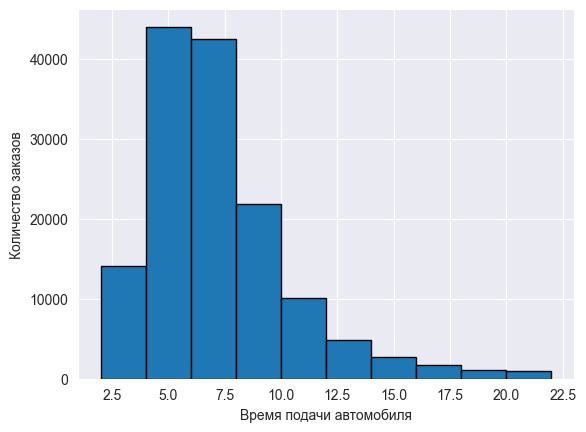

In [414]:
dataset['Расчетное время подачи'].plot(kind='hist', edgecolor='black',xlabel="Время подачи автомобиля", ylabel="Количество заказов")

In [415]:
import seaborn as sns
import matplotlib.pyplot as plt

# Матрица корреляции
# Где data - ваш датасет
correlation_matrix = dataset[['Расчетное время подачи', 'Нагрузка на район', 'Количество водителей в радиусе 500м', 'Количество водителей в радиусе 1000м','Количество водителей в радиусе 2000м', 'Расстояние до первого ближайшего водителя', 'Расстояние до второго ближайшего водителя', 'Расстояние до третьего ближайшего водителя' , 'Вероятность отказа от заказа водителя в радиусе 500м', 'Вероятность отказа от заказа водителя в радиусе 1000м', 'Вероятность отказа от заказа водителя в радиусе 2000м', 'Вероятность отказа от заказа первого ближайшего водителя', 'Вероятность отказа от заказа второго ближайшего водителя', 'Вероятность отказа от заказа третьего ближайшего водителя', 'Количество заказов вокруг']].corr()

dataset[['Расчетное время подачи', 'Нагрузка на район', 'Количество водителей в радиусе 500м', 'Количество водителей в радиусе 1000м','Количество водителей в радиусе 2000м', 'Расстояние до первого ближайшего водителя', 'Расстояние до второго ближайшего водителя', 'Расстояние до третьего ближайшего водителя' , 'Вероятность отказа от заказа водителя в радиусе 500м', 'Вероятность отказа от заказа водителя в радиусе 1000м', 'Вероятность отказа от заказа водителя в радиусе 2000м', 'Вероятность отказа от заказа первого ближайшего водителя', 'Вероятность отказа от заказа второго ближайшего водителя', 'Вероятность отказа от заказа третьего ближайшего водителя', 'Количество заказов вокруг']].corr()['Расчетное время подачи'][:].sort_values(ascending=False)

# # Выводим признаки на тепловую карт
# plt.figure(figsize= (15, 10))
# sns.heatmap(correlation_matrix, annot = True, cmap='coolwarm', fmt = '.2f')

Расчетное время подачи                                       1.000000
Расстояние до второго ближайшего водителя                    0.198162
Расстояние до третьего ближайшего водителя                   0.196650
Расстояние до первого ближайшего водителя                    0.188769
Вероятность отказа от заказа водителя в радиусе 500м         0.116089
Вероятность отказа от заказа водителя в радиусе 1000м        0.073124
Вероятность отказа от заказа водителя в радиусе 2000м        0.029580
Вероятность отказа от заказа первого ближайшего водителя     0.025799
Вероятность отказа от заказа второго ближайшего водителя     0.008979
Вероятность отказа от заказа третьего ближайшего водителя    0.002140
Нагрузка на район                                           -0.019168
Количество заказов вокруг                                   -0.035927
Количество водителей в радиусе 2000м                        -0.041443
Количество водителей в радиусе 1000м                        -0.068315
Количество водителей

In [612]:
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error
def show_learning_results(y_test, y_pred):
    y_pred = y_pred.round()
    delta_y = y_test - y_pred
    delta_y.plot(kind='hist', edgecolor='black', xlabel="Разница между истинным и прогнозируемым значением", ylabel="Количество заказов", figsize = (30, 15), fontsize = 20)

    print(r2_score(y_test, y_pred))
    print('Корень из средней квадратичной ошибки = ',root_mean_squared_error(y_test, y_pred))

    fig, ax = plt.subplots()  # Create a figure containing a single axes.
    ax.scatter(y_test, y_pred) 
    # Plot some data on the axes.
    delta_y = delta_y.abs()
    
    count_delta = len(delta_y)
    
    delta_y_less_1m = delta_y[delta_y <= 1]
    delta_y_less_2m = delta_y[delta_y <= 2]
    delta_y_less_3m = delta_y[delta_y <= 3]
    delta_y_less_4m = delta_y[delta_y <= 4]
    delta_y_more_5m = delta_y[delta_y >= 5]

    print(len(delta_y_less_1m) / count_delta * 100,'%', '- разница меньше минуты')
    print(len(delta_y_less_2m) / count_delta * 100,'%', '- разница меньше двух минут')
    print(len(delta_y_less_3m) / count_delta * 100,'%', '- разница меньше трех минут')
    print(len(delta_y_less_4m) / count_delta * 100,'%', '- разница меньше четырех минут')
    print(len(delta_y_more_5m) / count_delta * 100,'%', '- разница больше пяти минут')

In [703]:
def show_feature_importance(feature_importance, count):
    # Создаем отдельный датасет для визуализации
    final_df = pd.DataFrame({"Признак" : pd.DataFrame(X).columns, "Важность" : feature_importance})
    final_df.set_index('Важность')
    # Сортируем их по возрастанию для лучшей визуализации
    final_df = final_df.sort_values('Важность')
    # Выводим на график
    final_df.tail(count).plot.barh(x="Признак", color = 'teal', figsize = (20, 15), xlabel = 'Важность в %', ylabel = 'Признак', fontsize = 16)

In [418]:
Seed = 2024

In [734]:
from sklearn.model_selection import train_test_split

y = dataset['Расчетное время подачи']
X = dataset.drop(['Расчетное время подачи', 'DeltaTime', 'Date', 'OrderId', 'ArrivalDriverDate', 'OrderCreationDate', 'SetDriverDate'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=Seed)

In [545]:
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV

param_grid_randomized_search = {
    'iterations': np.arange(600, 3000, 200),
    'learning_rate': np.arange(0.01, 0.2, 0.02),
    'depth': np.arange(2, 12, 2)
}

cat_features = [3, 7]
model = CatBoostRegressor(verbose=False, cat_features=cat_features, loss_function='RMSE')
random_search = RandomizedSearchCV(model, param_grid_randomized_search, cv=5, n_jobs= 5, random_state=Seed, scoring='neg_root_mean_squared_error', n_iter=40)
random_search.fit(x_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_
y_pred = random_search.predict(x_test)

In [546]:
print(best_params)
print(best_score)

{'learning_rate': 0.03, 'iterations': 2600, 'depth': 6}
-2.9381379617950083


In [570]:
rs_df = pd.DataFrame(random_search.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'split3_test_score',
            'split4_test_score',
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_learning_rate,param_iterations,param_depth,mean_test_score,rank_test_score
0,0.03,2600,6,-2.938138,1
1,0.03,1200,6,-2.938584,2
2,0.05,600,6,-2.939602,3
3,0.13,1200,4,-2.941092,4
4,0.07,2400,2,-2.941683,5
5,0.03,1200,4,-2.941769,6
6,0.11,1600,2,-2.942049,7
7,0.17,1200,2,-2.942646,8
8,0.13,1200,2,-2.942709,9
9,0.19,800,2,-2.943155,10


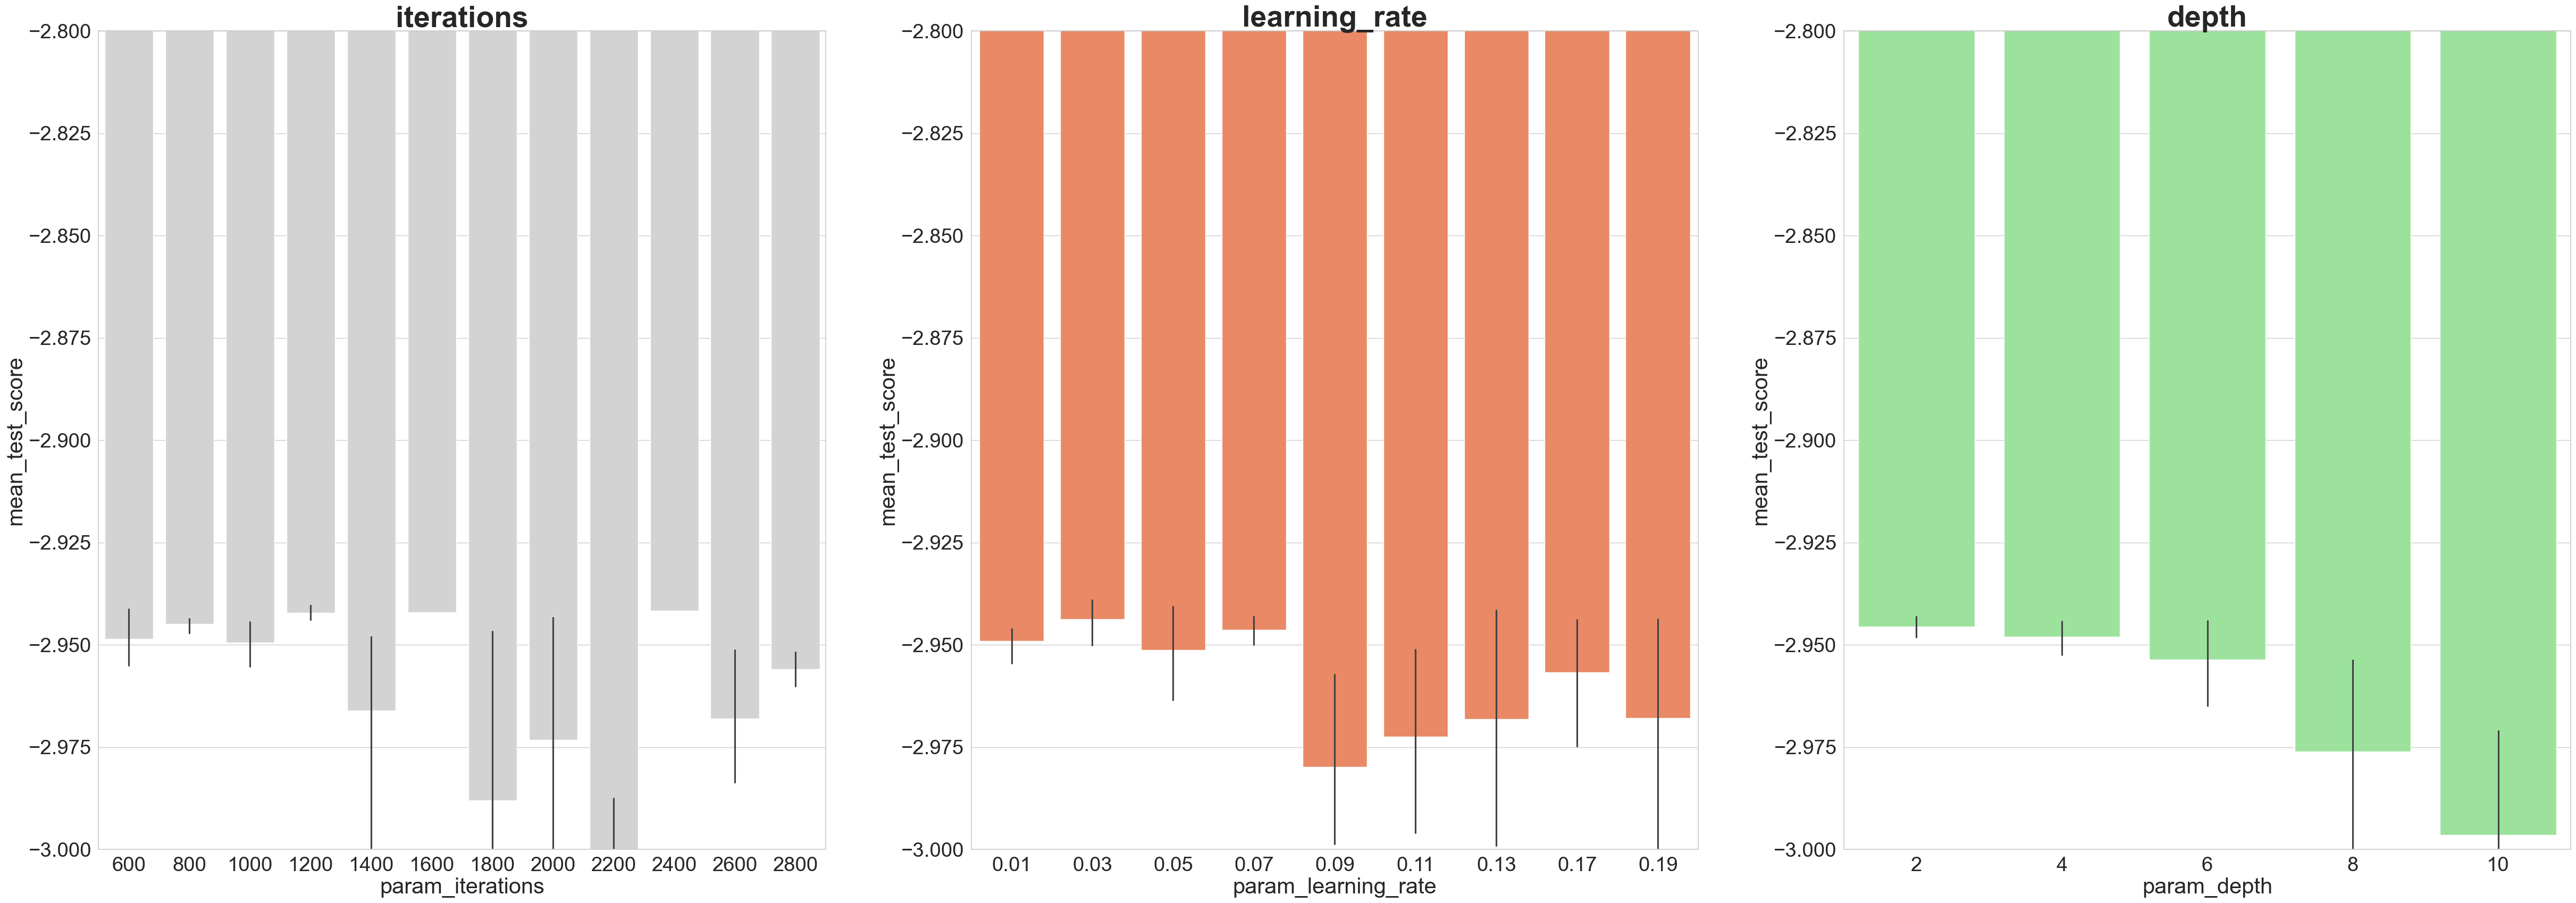

In [589]:
fig, axs = plt.subplots(ncols=3)
sns.set(style="whitegrid", color_codes=True, font_scale=2.9)
fig.set_size_inches(60, 20)
sns.barplot(x='param_iterations', y='mean_test_score', data=rs_df, ax=axs[0], color='lightgrey')
axs[0].set_ylim([-3, -2.8])
axs[0].set_title(label='iterations', size=40, weight='bold')
sns.barplot(x=rs_df['param_learning_rate'].astype(np.float32), y=rs_df['mean_test_score'], ax=axs[1], color='coral')
axs[1].set_ylim([-3, -2.8])
axs[1].set_title(label='learning_rate', size=40, weight='bold')
sns.barplot(x='param_depth', y='mean_test_score', data=rs_df, ax=axs[2], color='lightgreen')
axs[2].set_ylim([-3, -2.8])
axs[2].set_title(label='depth', size=40, weight='bold')
plt.show()

In [591]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'iterations': [600,800,1000,1200,1600,2400,2800],
    'learning_rate': [0.01,0.03,0.05,0.7,0.17],
    'depth': [2,4,6]
}

cat_features = [3, 7]
model = CatBoostRegressor(verbose=False, cat_features=cat_features, loss_function='RMSE')
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs= 5, scoring='neg_root_mean_squared_error')
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
y_pred = grid_search.predict(x_test)

In [593]:
print(best_params)
print(best_score)

{'depth': 6, 'iterations': 1600, 'learning_rate': 0.03}
-2.9374298919765875


0.15215949886671143
Корень из средней квадратичной ошибки =  2.927233901007904
44.843283063451246 % - разница меньше минуты
68.6218639238307 % - разница меньше двух минут
84.35610535825978 % - разница меньше трех минут
91.09736604350546 % - разница меньше четырех минут
8.902633956494546 % - разница больше пяти минут


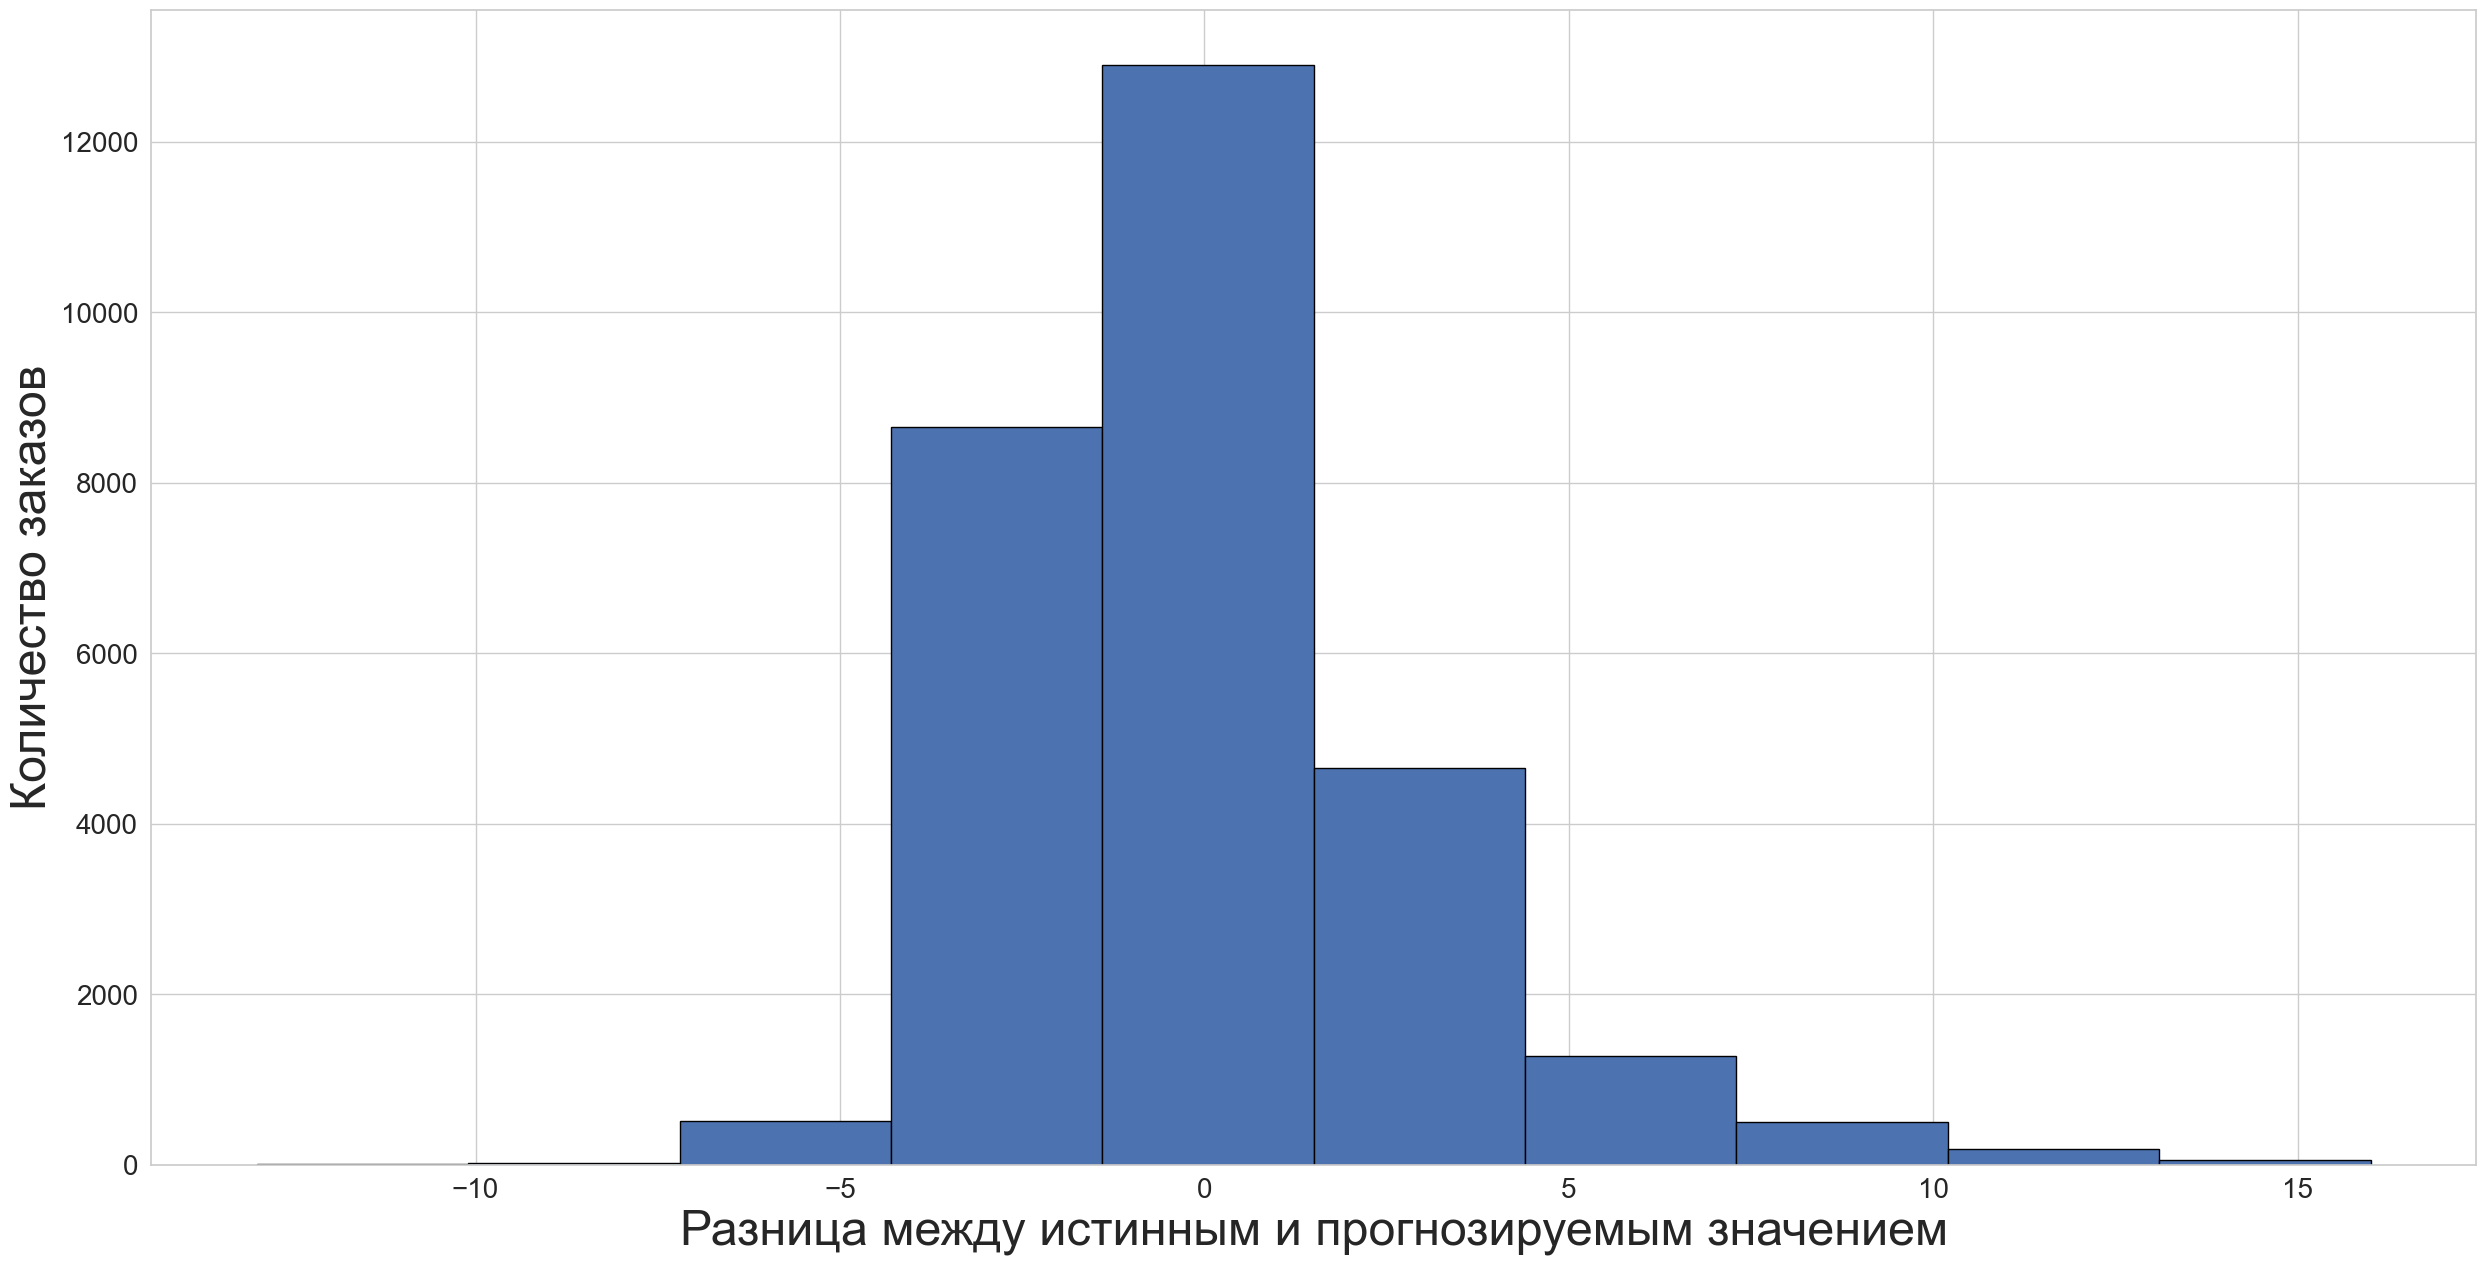

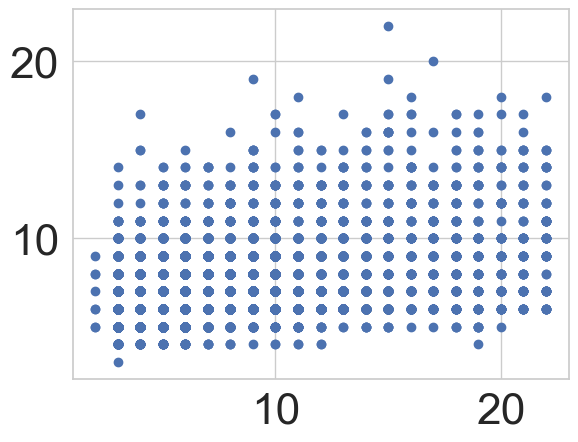

In [613]:
show_learning_results(y_test, y_pred)

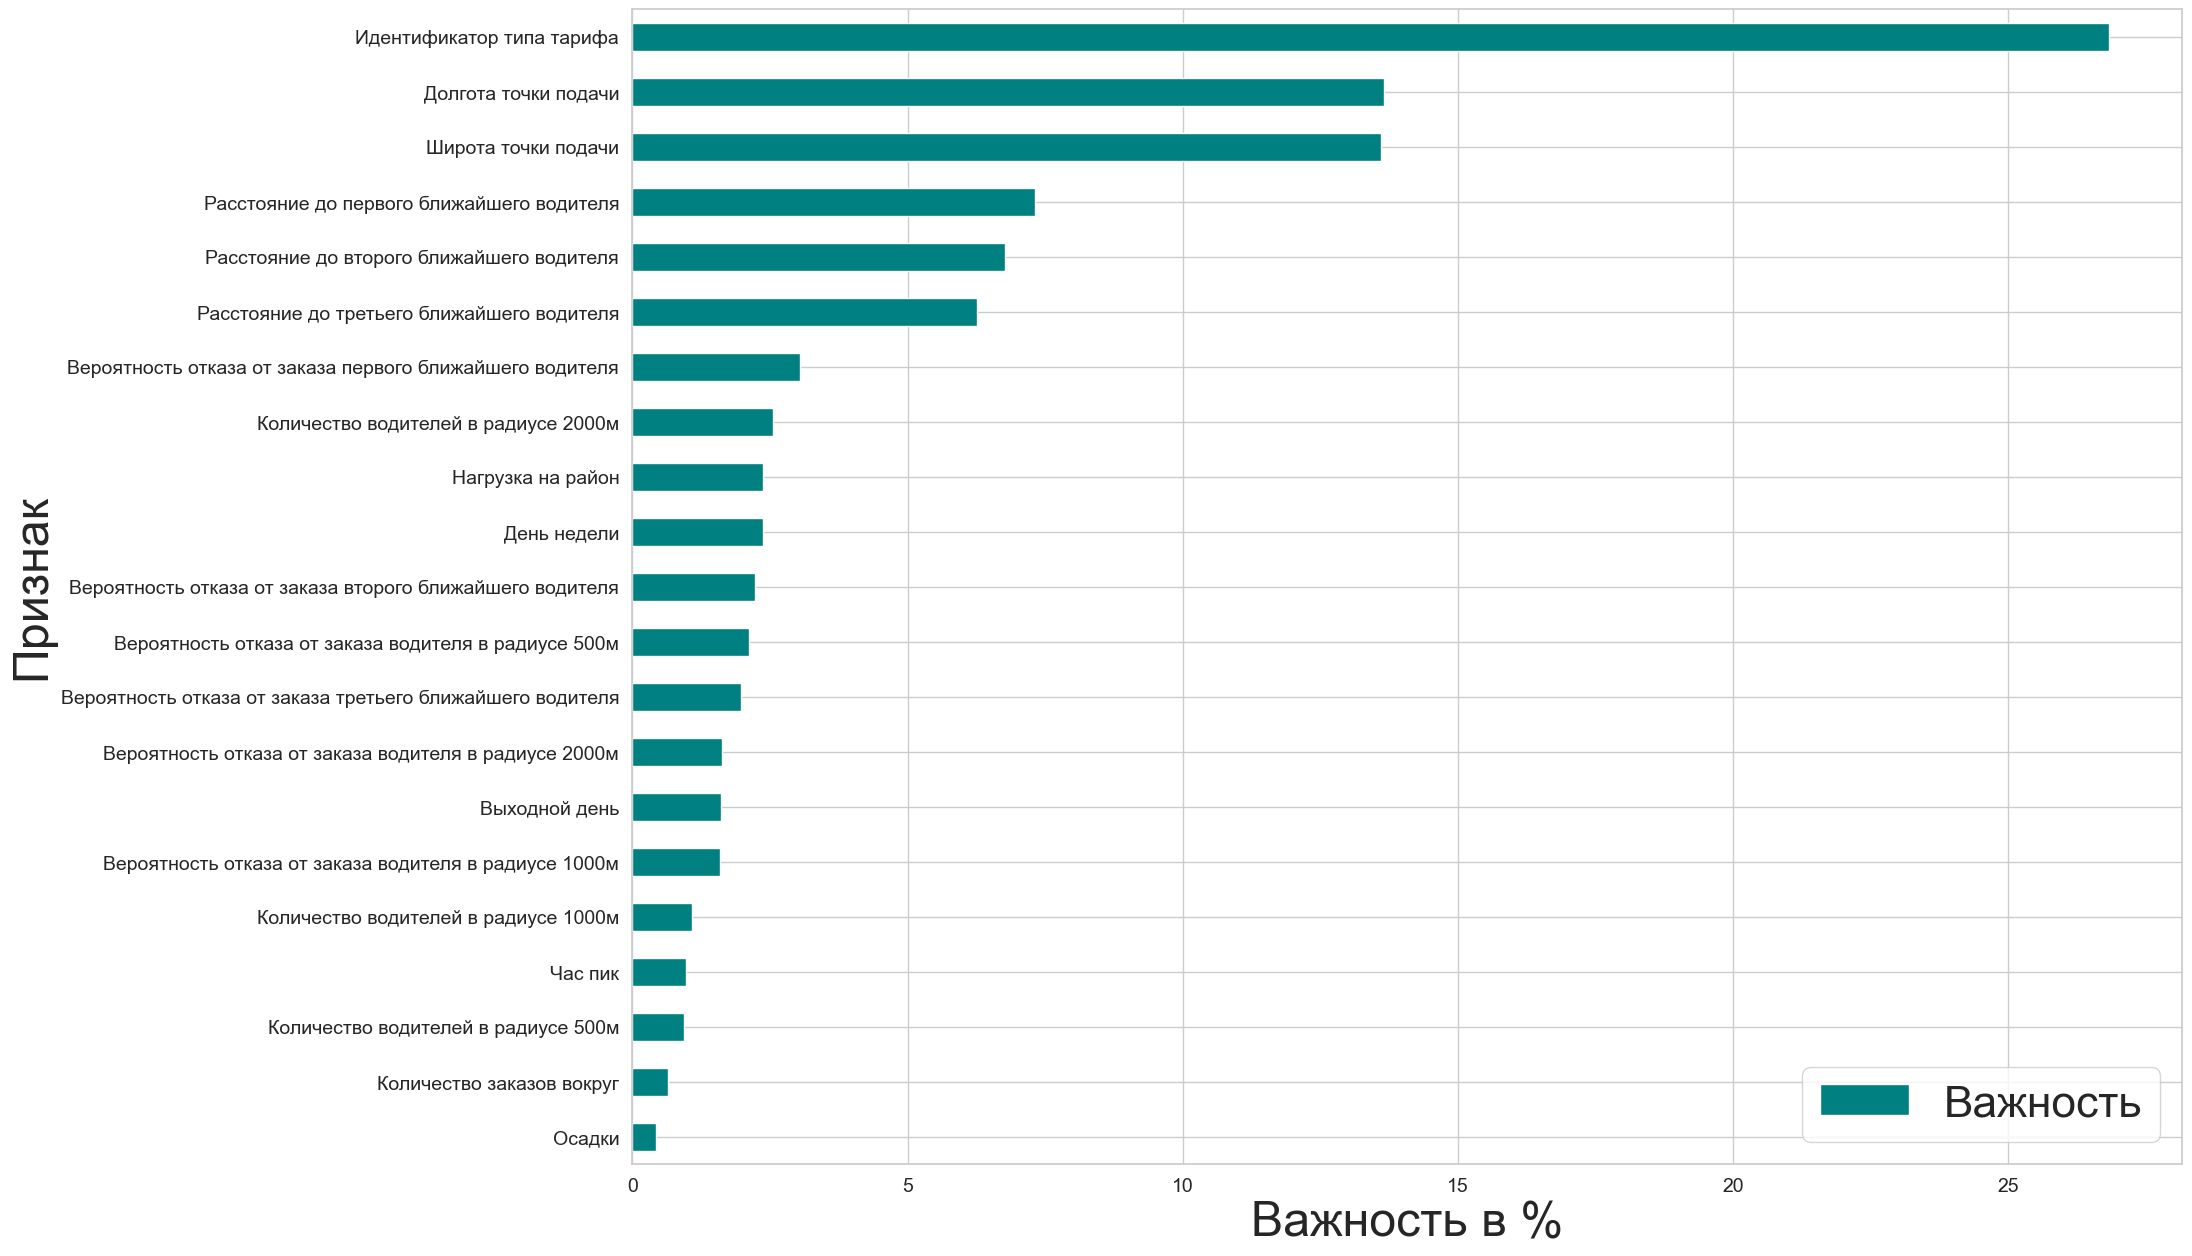

In [618]:
show_feature_importance(grid_search.best_estimator_.feature_importances_, 21)

In [680]:
one_hot_encoded_data = pd.get_dummies(dataset, columns = ['Идентификатор типа тарифа', 'День недели'])
print(one_hot_encoded_data)

           OrderId  Расчетное время подачи           SetDriverDate  \
0       3544585460                       5 2024-02-15 00:18:53.997   
1       3544585488                       4 2024-02-15 00:01:58.203   
2       3544585545                       4 2024-02-15 00:10:47.800   
3       3544585571                       3 2024-02-15 00:06:58.673   
4       3544585572                       5 2024-02-15 00:05:40.380   
...            ...                     ...                     ...   
145643  3549499846                      18 2024-03-13 23:46:41.800   
145644  3549499955                      10 2024-03-13 23:51:20.557   
145645  3549499961                       4 2024-03-13 23:58:55.290   
145646  3549500025                       5 2024-03-13 23:56:31.047   
145647  3549500125                      12 2024-03-14 00:01:33.953   

             ArrivalDriverDate       OrderCreationDate  Нагрузка на район  \
0      2024-02-15 00:20:10.647 2024-02-15 05:00:25.540               1.25   
1    

In [620]:
display(one_hot_encoded_data)

y = one_hot_encoded_data['Расчетное время подачи']
X = one_hot_encoded_data.drop(['Расчетное время подачи', 'DeltaTime', 'Date', 'OrderId', 'ArrivalDriverDate', 'OrderCreationDate', 'SetDriverDate'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=Seed)

,OrderId,Расчетное время подачи,SetDriverDate,ArrivalDriverDate,OrderCreationDate,Нагрузка на район,Широта точки подачи,Долгота точки подачи,Выходной день,Час пик,...,Идентификатор типа тарифа_1456,Идентификатор типа тарифа_1457,Идентификатор типа тарифа_1475,День недели_Воскресенье,День недели_Вторник,День недели_Понедельник,День недели_Пятница,День недели_Среда,День недели_Суббота,День недели_Четверг
0,3544585460,5,2024-02-15 00:18:53.997,2024-02-15 00:20:10.647,2024-02-15 05:00:25.540,1.25,57.181877,65.656975,0,0,...,False,False,False,False,False,False,False,False,False,True
1,3544585488,4,2024-02-15 00:01:58.203,2024-02-15 00:03:33.630,2024-02-15 05:00:58.053,1.35,57.127262,65.581718,0,0,...,False,False,False,False,False,False,False,False,False,True
2,3544585545,4,2024-02-15 00:10:47.800,2024-02-15 00:13:19.677,2024-02-15 05:02:45.250,1.20,57.146118,65.522736,0,0,...,False,False,False,False,False,False,False,False,False,True
3,3544585571,3,2024-02-15 00:06:58.673,2024-02-15 00:07:50.340,2024-02-15 05:03:29.623,1.25,57.146656,65.521637,0,0,...,False,False,False,False,False,False,False,False,False,True
4,3544585572,5,2024-02-15 00:05:40.380,2024-02-15 00:10:34.873,2024-02-15 05:03:29.733,1.35,57.145397,65.585876,0,0,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145643,3549499846,18,2024-03-13 23:46:41.800,2024-03-14 00:05:44.097,2024-03-14 04:44:52.303,1.00,57.115326,65.560928,0,0,...,False,False,False,False,False,False,False,False,False,True
145644,3549499955,10,2024-03-13 23:51:20.557,2024-03-14 00:02:07.323,2024-03-14 04:49:52.080,1.00,57.146118,65.522736,0,0,...,False,False,False,False,False,False,False,False,False,True
145645,3549499961,4,2024-03-13 23:58:55.290,2024-03-13 23:59:51.967,2024-03-14 04:50:22.870,1.25,57.147602,65.642136,0,0,...,False,False,False,False,False,False,False,False,False,True
145646,3549500025,5,2024-03-13 23:56:31.047,2024-03-14 00:00:43.637,2024-03-14 04:53:47.267,1.25,57.095970,65.566177,0,0,...,False,False,False,False,False,False,False,False,False,True


In [634]:
from sklearn.ensemble import RandomForestRegressor
param_grid = {
    'n_estimators': np.arange(200, 800, 50),
    'max_depth': np.arange(10, 120, 10),
    'max_features': ['log2', 'sqrt'],
    'min_samples_split': np.arange(2, 103, 10),
    'min_samples_leaf': np.arange(1, 11, 1),
    'bootstrap': [True, False]
}

model = RandomForestRegressor(random_state=Seed)
random_search = RandomizedSearchCV(model, param_grid, cv=5, n_jobs= 5, random_state=Seed, scoring='neg_root_mean_squared_error', n_iter=40)
random_search.fit(x_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_
y_pred = random_search.predict(x_test)
print(best_params)
print(best_score)

{'n_estimators': 350, 'min_samples_split': 72, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': False}
-2.9595369592736374


In [635]:
rs_df = pd.DataFrame(random_search.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,split3_test_score,split4_test_score,mean_test_score,rank_test_score
0,350,72,1,sqrt,90,False,-2.968814,-2.975168,-2.959537,1
1,400,52,3,sqrt,90,False,-2.968862,-2.975527,-2.959916,2
2,500,42,4,sqrt,90,False,-2.969255,-2.975932,-2.960146,3
3,350,82,4,sqrt,80,False,-2.968690,-2.976228,-2.960354,4
4,550,32,2,sqrt,20,True,-2.969730,-2.975214,-2.960538,5
5,550,62,7,sqrt,90,False,-2.969636,-2.977587,-2.961347,6
6,750,72,2,sqrt,20,True,-2.970260,-2.976137,-2.961626,7
7,650,92,6,sqrt,20,False,-2.969898,-2.976663,-2.961777,8
8,350,102,1,log2,80,False,-2.970721,-2.976725,-2.961974,9
9,300,62,2,log2,80,False,-2.972341,-2.977085,-2.962033,10


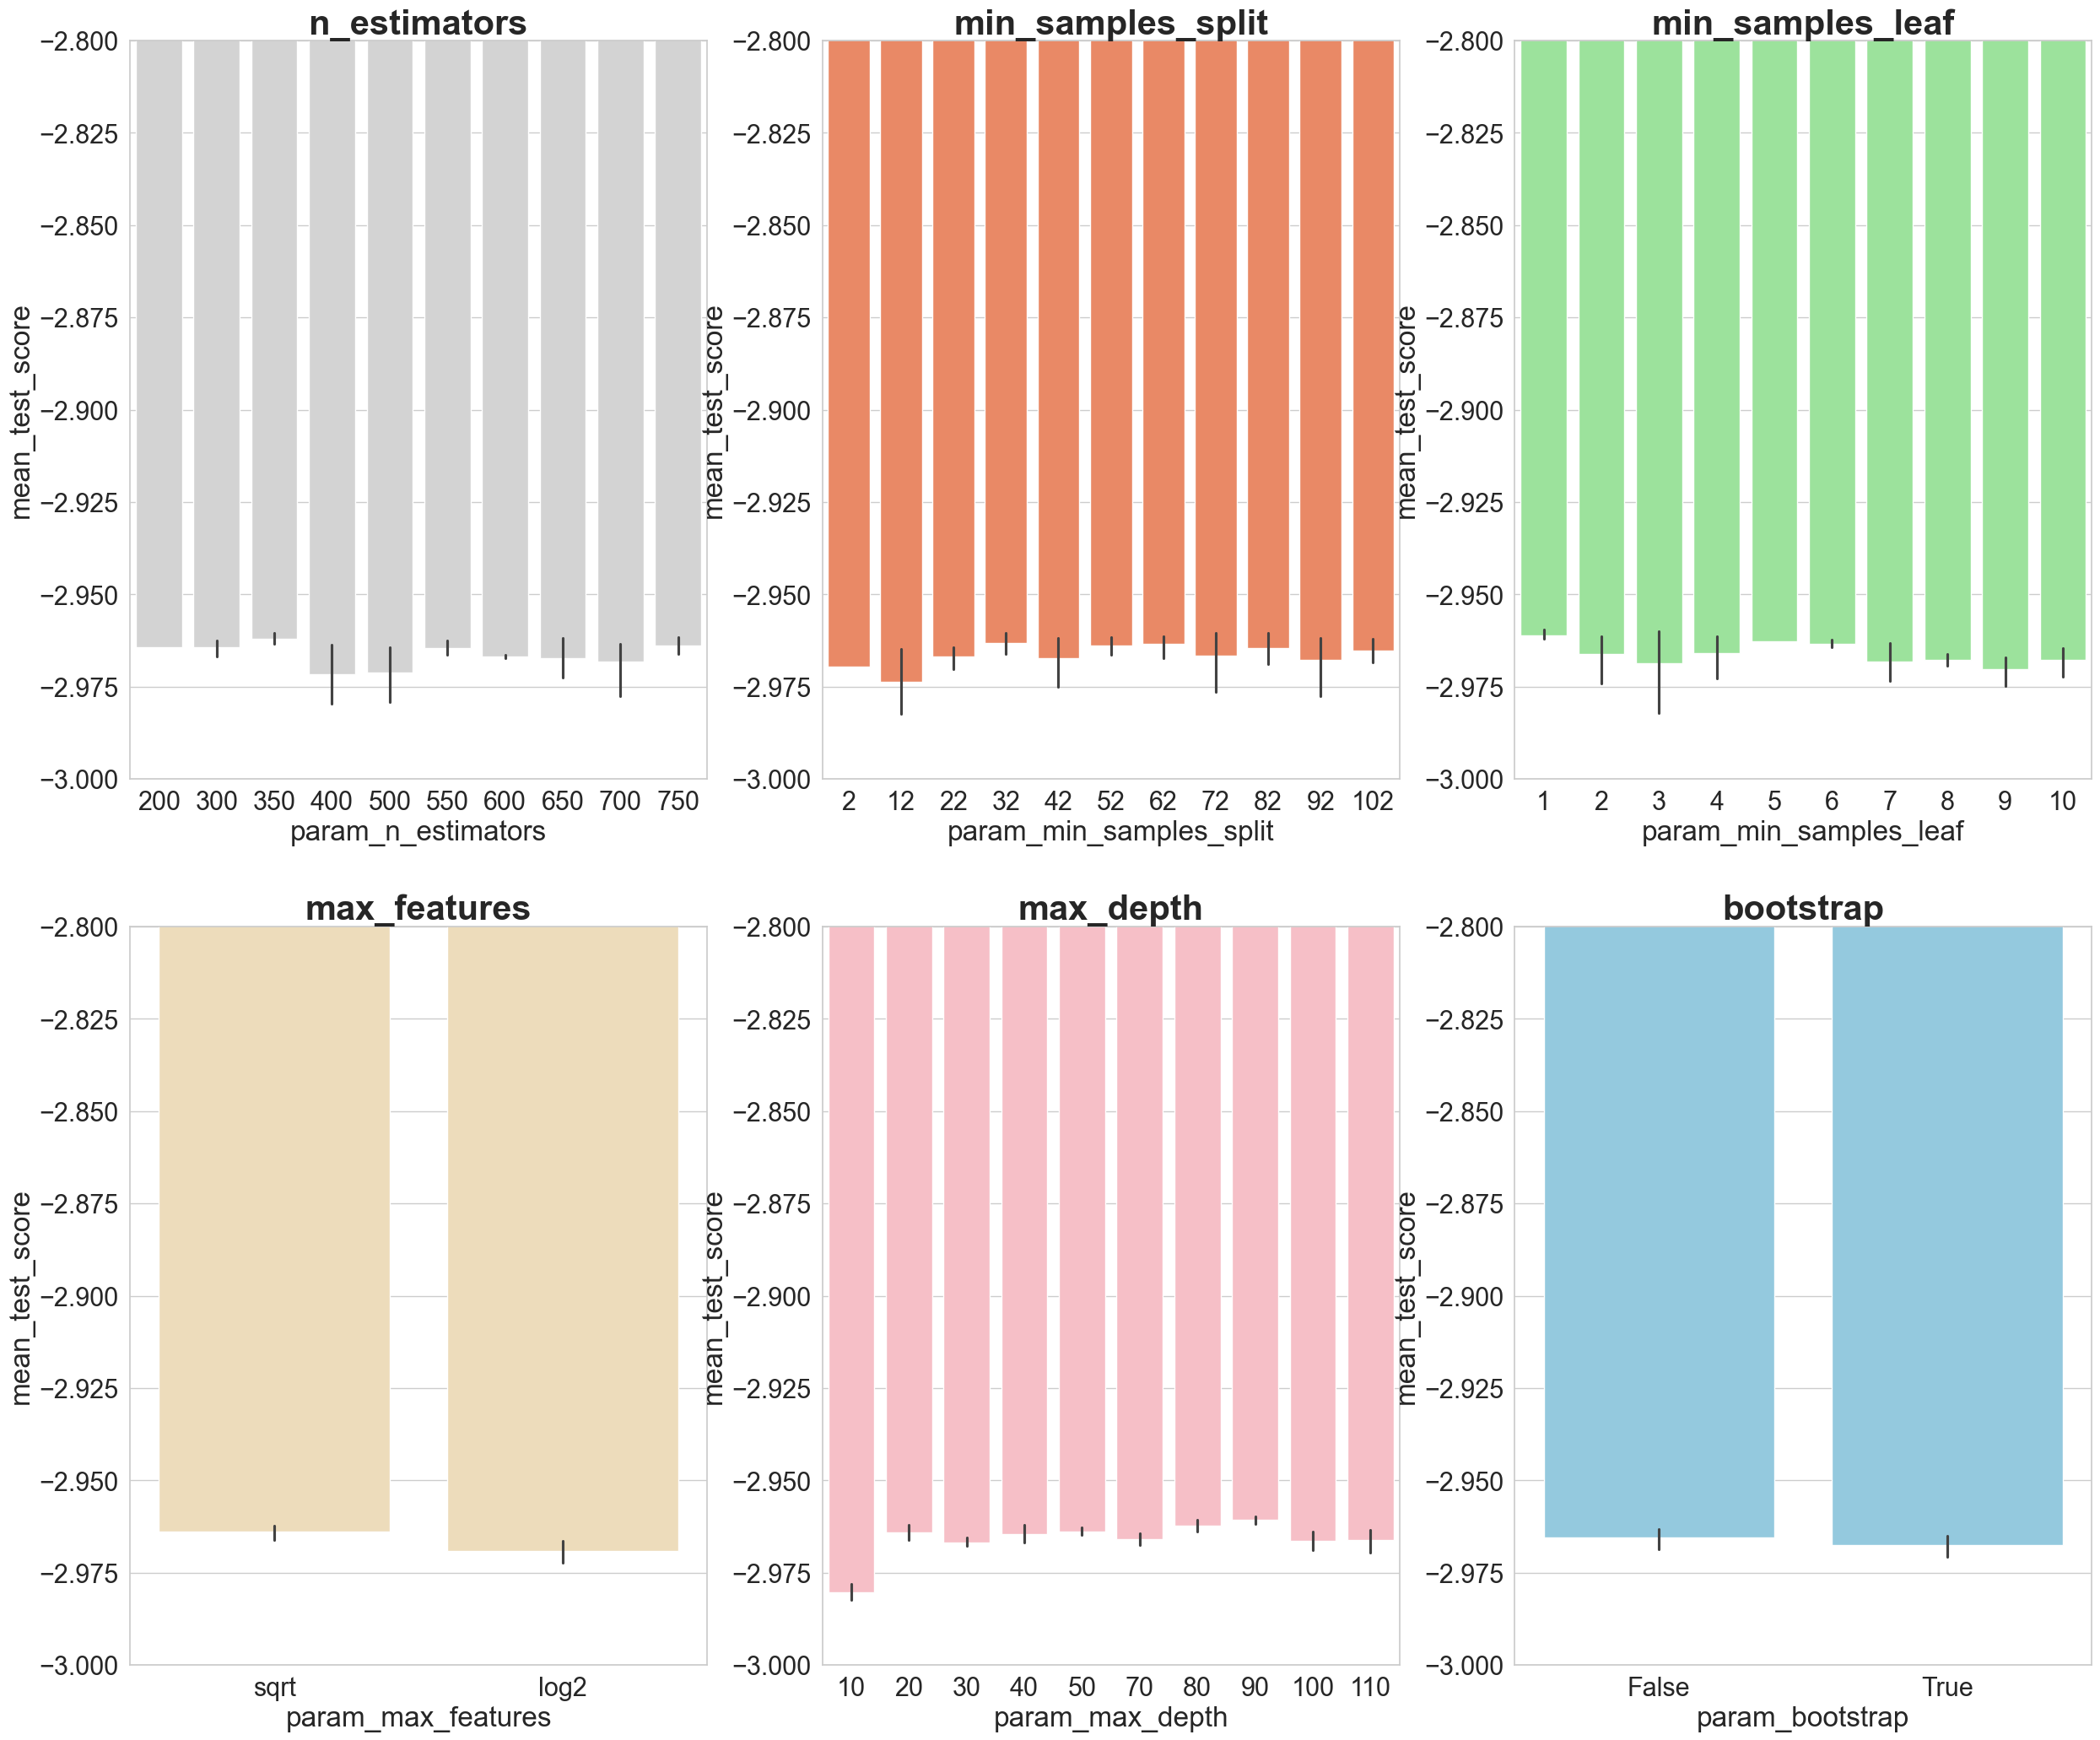

In [638]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([-3, -2.8])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([-3, -2.8])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([-3, -2.8])
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([-3, -2.8])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([-3, -2.8])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([-3, -2.8])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

In [640]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [350, 550, 650, 700, 750],
    'max_depth': [20, 40, 50, 80, 90],
    'min_samples_split': [32, 52, 62, 72, 82, 102],
    'min_samples_leaf': [1, 3, 4, 5, 6, 7],
}

cat_features = [3, 7]
model = RandomForestRegressor(random_state=Seed, bootstrap=False, max_features='sqrt')
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs= 5, scoring='neg_root_mean_squared_error')
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
y_pred = grid_search.predict(x_test)

In [641]:
print(best_params)
print(best_score)

{'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 62, 'n_estimators': 550}
-2.958751150244691


0.14131178897954844
Корень из средней квадратичной ошибки =  2.9459006550223723
44.12398359858225 % - разница меньше минуты
67.54812704149002 % - разница меньше двух минут
84.04336646049066 % - разница меньше трех минут
91.0070192508166 % - разница меньше четырех минут
8.992980749183404 % - разница больше пяти минут


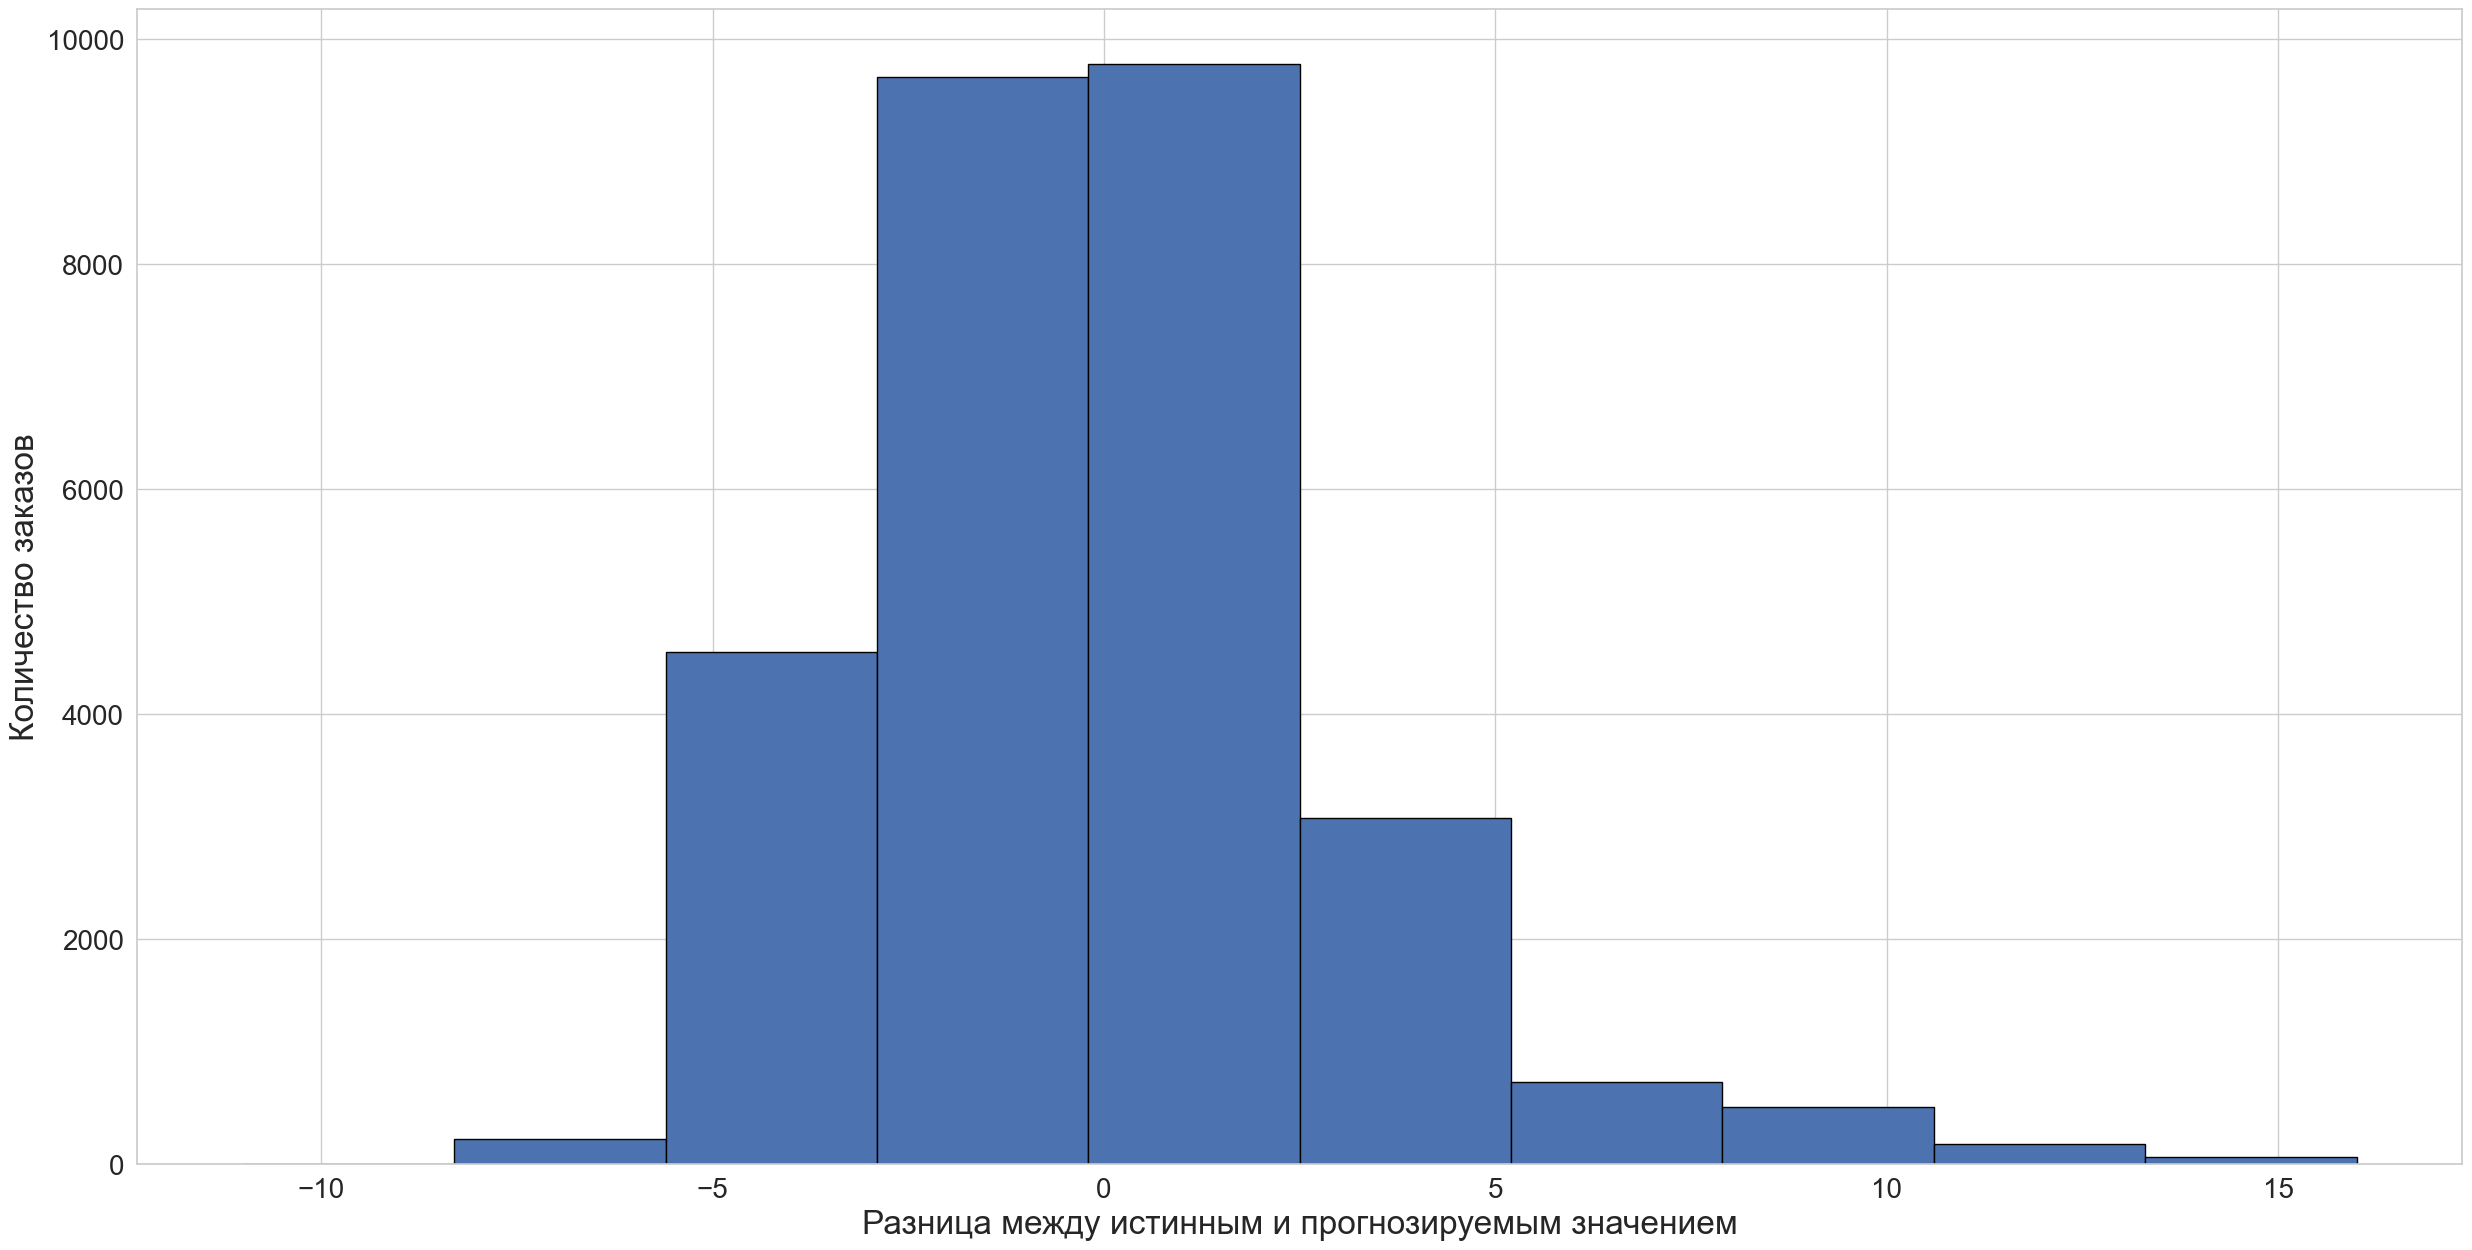

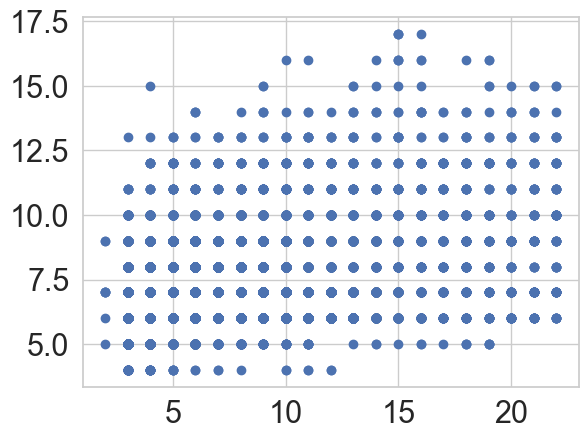

In [642]:
show_learning_results(y_test, y_pred)

In [704]:
show_feature_importance(grid_search.best_estimator_.feature_importances_, 15)

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [681]:
# импортируем класс MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
 
y = one_hot_encoded_data['Расчетное время подачи']
# создаем объект этого класса,
# в параметре feature_range оставим диапазон по умолчанию
one_hot_encoded_data = one_hot_encoded_data.drop(['Расчетное время подачи','DeltaTime', 'Date', 'OrderId', 'ArrivalDriverDate', 'OrderCreationDate', 'SetDriverDate'], axis=1)
minmax = MinMaxScaler(feature_range = (0, 1))
one_hot_encoded_data_scaled = minmax.fit_transform(one_hot_encoded_data)
# преобразуем результаты в датафрейм
one_hot_encoded_data_scaled = pd.DataFrame(one_hot_encoded_data_scaled, columns = one_hot_encoded_data.columns)
display(one_hot_encoded_data_scaled)
X = one_hot_encoded_data_scaled

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=Seed)

,Нагрузка на район,Широта точки подачи,Долгота точки подачи,Выходной день,Час пик,Осадки,Количество водителей в радиусе 500м,Количество водителей в радиусе 1000м,Количество водителей в радиусе 2000м,Расстояние до первого ближайшего водителя,...,Идентификатор типа тарифа_1456,Идентификатор типа тарифа_1457,Идентификатор типа тарифа_1475,День недели_Воскресенье,День недели_Вторник,День недели_Понедельник,День недели_Пятница,День недели_Среда,День недели_Суббота,День недели_Четверг
0,0.5,0.599448,0.587795,0.0,0.0,0.0,0.000000,0.00,0.033333,0.039008,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.7,0.491556,0.511799,0.0,0.0,0.0,0.052632,0.20,0.066667,0.012218,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.4,0.528806,0.452237,0.0,0.0,0.0,0.210526,0.08,0.066667,0.003959,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.5,0.529869,0.451128,0.0,0.0,0.0,0.210526,0.08,0.083333,0.001570,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.7,0.527382,0.515998,0.0,0.0,0.0,0.000000,0.04,0.083333,0.032626,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143882,0.0,0.467976,0.490805,0.0,0.0,0.0,0.157895,0.08,0.116667,0.007747,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
143883,0.0,0.528806,0.452237,0.0,0.0,0.0,0.210526,0.12,0.133333,0.002287,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
143884,0.5,0.531738,0.572810,0.0,0.0,0.0,0.000000,0.04,0.033333,0.026585,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
143885,0.5,0.429738,0.496105,0.0,0.0,0.0,0.052632,0.00,0.033333,0.011433,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [722]:
from sklearn.svm import SVR
param_grid = {
    'kernel': ['rbf', 'poly', 'linear'],
    'C': np.arange(1.4, 4.1, 0.2), 
    'epsilon': np.arange(1.4, 4.1, 0.2), 
}

svr = SVR()

random_search = RandomizedSearchCV(svr, param_grid, cv=3, n_jobs= 5, random_state=Seed, scoring='neg_root_mean_squared_error', n_iter=15)
random_search.fit(x_train, y_train)
best_params = random_search.best_params_
best_score = random_search.best_score_
y_pred = random_search.predict(x_test)
print(best_params)
print(best_score)

{'kernel': 'rbf', 'epsilon': 2.5999999999999996, 'C': 2.9999999999999996}
-2.9836091969829153


In [723]:
rs_df = pd.DataFrame(random_search.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_kernel,param_epsilon,param_C,mean_test_score,rank_test_score
0,rbf,2.6,3.0,-2.983609,1
1,rbf,2.2,3.8,-2.987892,2
2,linear,2.6,3.2,-2.988874,3
3,linear,2.6,3.6,-2.988906,4
4,rbf,3.0,1.8,-2.989458,5
5,linear,3.0,2.4,-2.989592,6
6,poly,2.2,2.6,-2.992221,7
7,rbf,3.2,1.6,-2.996477,8
8,linear,3.2,3.8,-2.996750,9
9,rbf,3.4,2.6,-3.003939,10


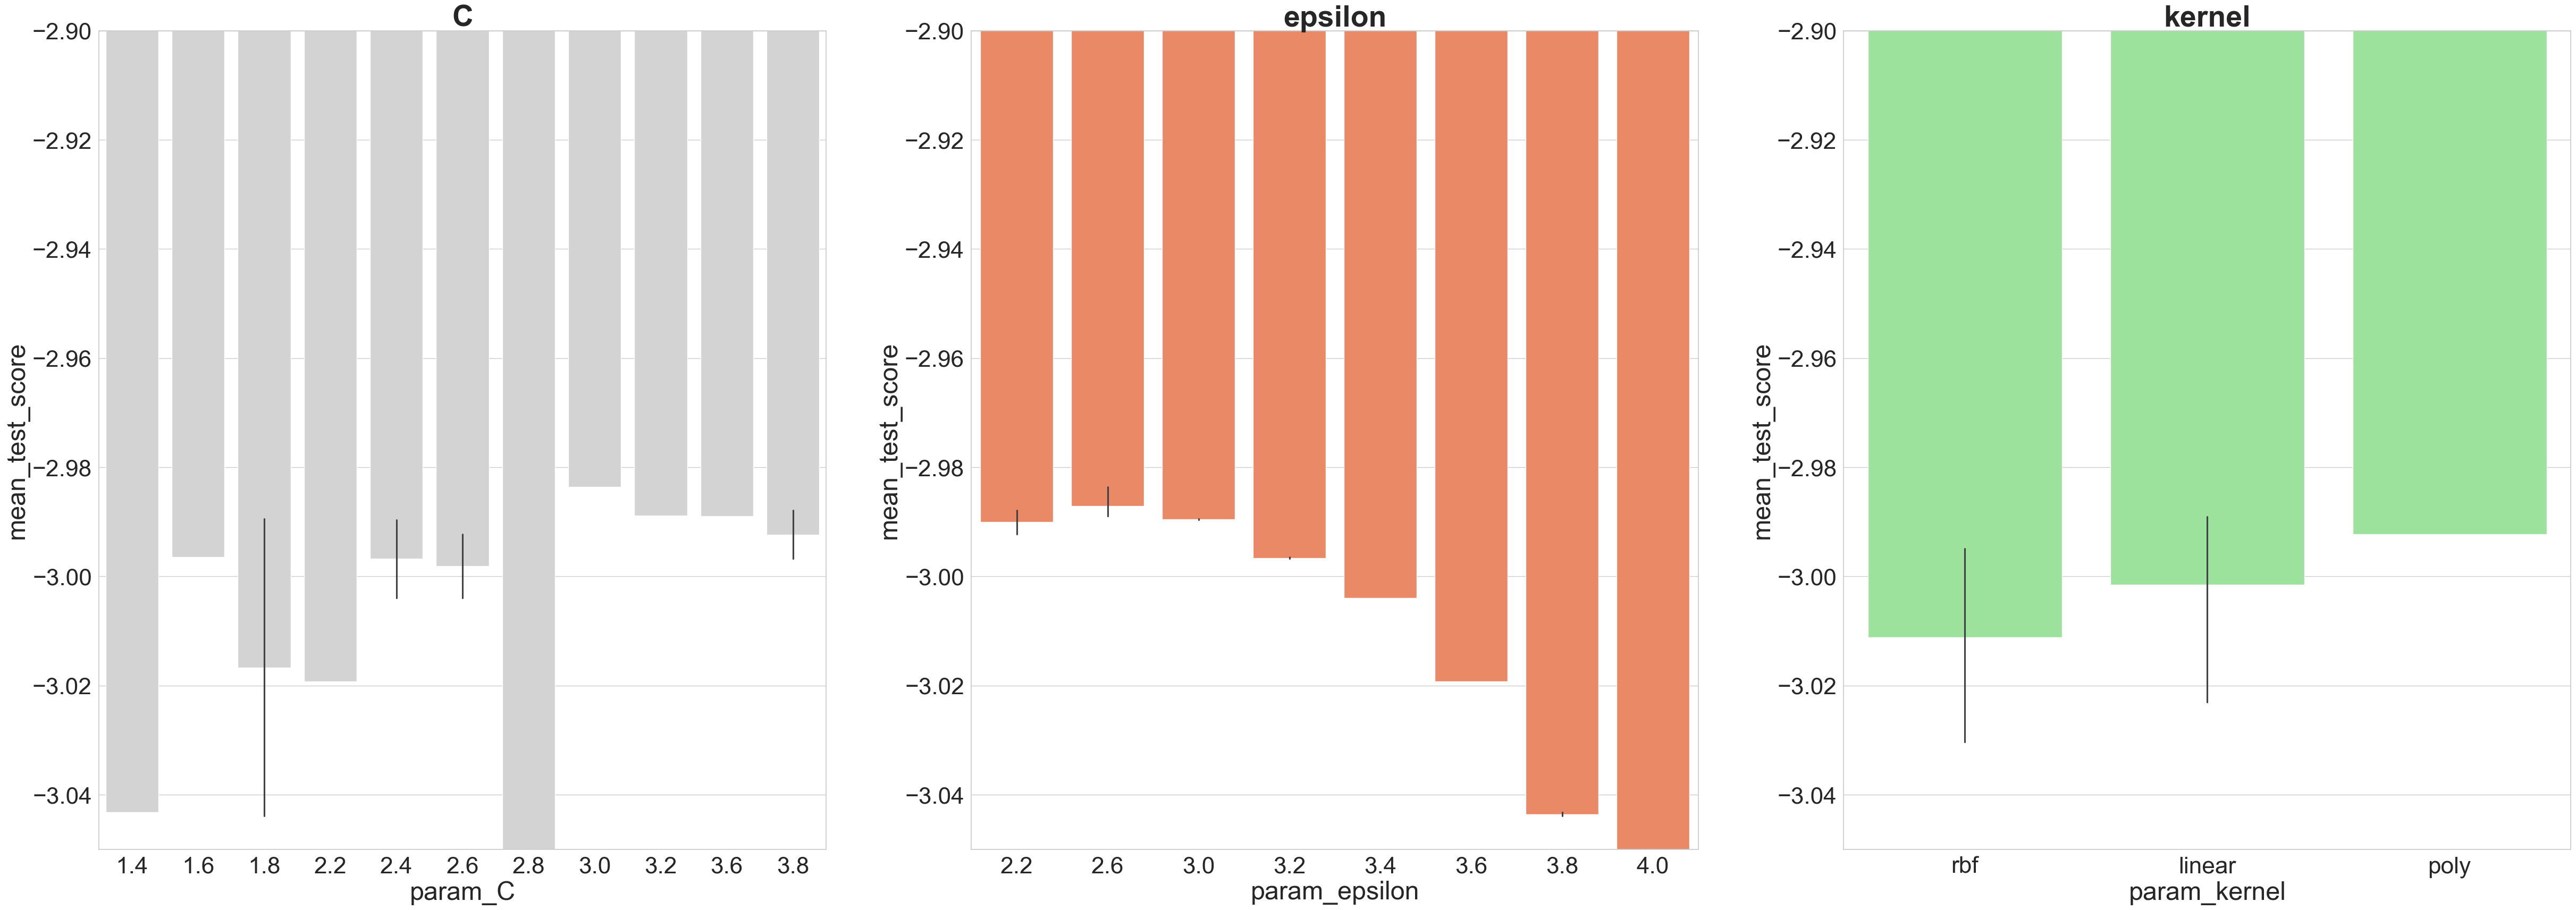

In [727]:
fig, axs = plt.subplots(ncols=3)
sns.set(style="whitegrid", color_codes=True, font_scale=2.9)
fig.set_size_inches(60, 20)
sns.barplot(x=rs_df['param_C'].astype(np.float32), y=rs_df['mean_test_score'], ax=axs[0], color='lightgrey')
axs[0].set_ylim([-3.05, -2.9])
axs[0].set_title(label='C', size=40, weight='bold')
sns.barplot(x=rs_df['param_epsilon'].astype(np.float32), y=rs_df['mean_test_score'], ax=axs[1], color='coral')
axs[1].set_ylim([-3.05, -2.9])
axs[1].set_title(label='epsilon', size=40, weight='bold')
sns.barplot(x='param_kernel', y='mean_test_score', data=rs_df, ax=axs[2], color='lightgreen')
axs[2].set_ylim([-3.05, -2.9])
axs[2].set_title(label = 'kernel', size=40, weight='bold')
plt.show()

In [728]:
param_grid = {
    'kernel': ['rbf', 'poly'],
    'C': [3, 3.2, 3.4, 3.6], 
    'epsilon': [2.2, 2.6, 3], 
}

model = SVR()

grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs= 5, scoring='neg_root_mean_squared_error')
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
y_pred = grid_search.predict(x_test)

In [732]:
print(best_params)
print(best_score)

{'C': 3, 'epsilon': 2.6, 'kernel': 'rbf'}
-2.982713601173681


0.12715303483839557
Корень из средней квадратичной ошибки =  2.970088565914126
43.564528459239696 % - разница меньше минуты
66.91222461602612 % - разница меньше двух минут
84.10938911668636 % - разница меньше трех минут
91.26068524567378 % - разница меньше четырех минут
8.739314754326221 % - разница больше пяти минут


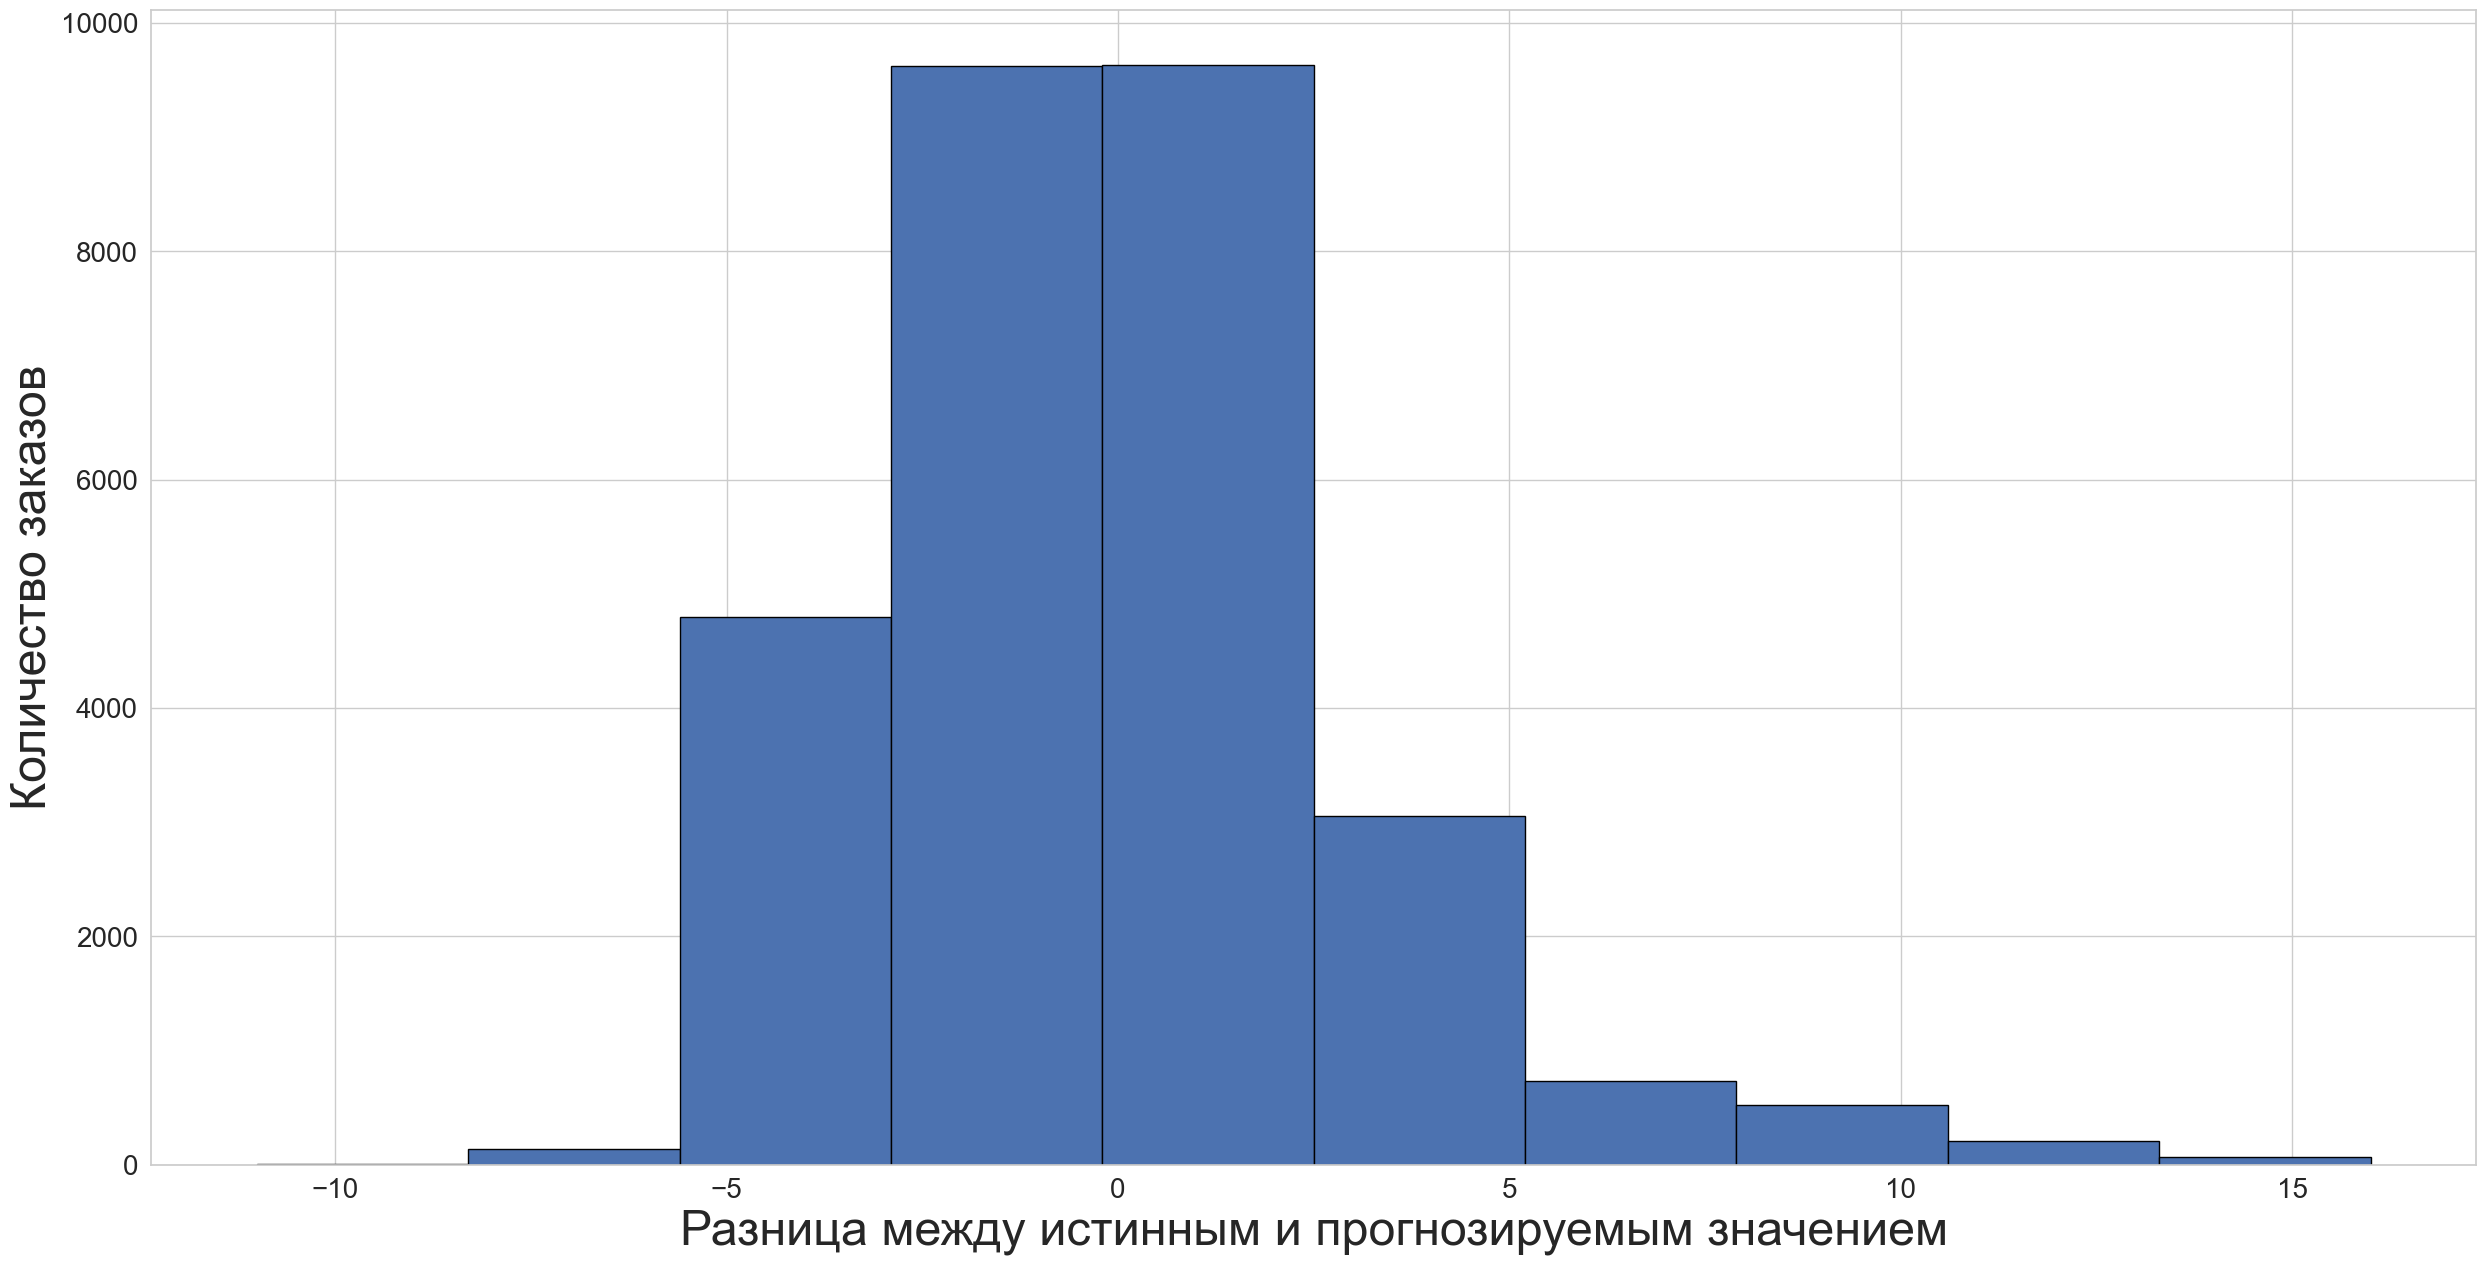

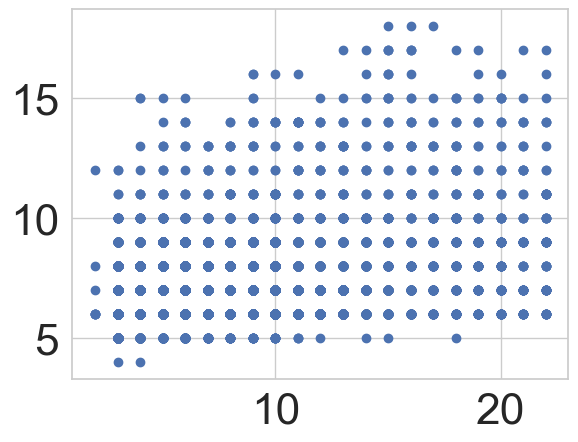

In [733]:
show_learning_results(y_test, y_pred)